# Курсовой проект по  курсу "Python для Data Science"

преподаватель Корлякова Мария                                          
студент Иванов Андрей



Материалы к проекту (файлы):
train.csv
test.csv

Задание:
Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

Целевая переменная:
Price

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл с названием по образцу SShirkin_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).
В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний).

Сроки и условия сдачи:
Дедлайн: сдать проект нужно в течение 72 часов после начала Урока 10 ("Вебинар. Консультация по итоговому проекту").
Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6.
При сдаче до дедлайна результат проекта может попасть в топ лучших результатов.
Повторная сдача и проверка результатов возможны только при условии предыдущей неуспешной сдачи.
Успешный проект нельзя пересдать в целях повышения результата.
Проекты, сданные после дедлайна или сданные повторно, не попадают в топ лучших результатов, но можно узнать результат.
В качестве итогового результата берется первый успешный результат, последующие успешные результаты не учитываются.

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать 
статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию,
но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.
9. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearch с перебором 
большого количества сочетаний параметров.
10. Допускается применение библиотек Python и моделей машинного обучения,
которые были в курсе Python для Data Science. Градиентный бустинг изучается
в последующих курсах, поэтому в этом проекте его применять не следует.
Самая сложная из допустимых моделей - RandomForestRegressor из sklearn.

# Подготовка рабочего пространства

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from scipy import stats

TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

In [2]:
# Вспомогательная функция для печати размера датафрейма
def pdim(df, df_name):
    print('Dimensions "' +df_name+'" ', df.shape, type(df))

In [3]:
# Вспомогательная функция для печати информации о столбцах дататафрейма содержащих данные NULL 
def col_with_NULL(df):
    temp_ser = df.isnull().astype(np.int).sum().astype(np.int)
    row_with_null = temp_ser[temp_ser!= 0]
    print(f'Столбцы содержащие NULL:\n{row_with_null}')

In [4]:
# Вспомогательная функция для печати информации о датафрейме
def df_info(df):
    print(f'Информация о данных датафрейма:')
    df_information=df.info(memory_usage='deep')
    print("-" * 42)

In [5]:
# Вспомогательная функция для вычисления наиболее часто встречающегося соотношения между признаками,
# значение 0 для признака - не  приемлимо,lim1 и  lim2 - предельные максимальные значения признака для которых 
# функция не вычисляются. Признак  sign1 всегда <= sign2  
def df_kfs_means(df, df_name, sign1, lim1, sign2, lim2, coefficient_name): 
    temp = df.copy(deep=True)
    temp = temp.loc[(temp[sign1] != 0) & (temp[sign2] != 0) & (temp[sign1]<lim1) & (temp[sign2]<lim2) & (temp[sign2]>=temp[sign1]) ]
    temp [coefficient_name] = temp[sign1]/temp[sign2]
    k = 0.5*(temp[coefficient_name].mean()+temp[coefficient_name].median())
    print(f'Значение к-та для {df_name} составляет:{coefficient_name} = {k}')
    return k

In [6]:
# Вспомогательная функция для заполнения вычисляемых полей датафрейма с использованием ранее вычисленных к-тов
# Значение 0 для признака - не  приемлимо,lim1 и  lim2 - предельные значения диапазона изменения coefficient 
# функция не вычисляются. Признак  sign1 всегда  sign2  
def df_recalc_sign(df, df_name, sign1, lim1, sign2, lim2, coefficient): 
    temp = df.copy(deep=True)
    temp.loc[(temp[sign1] < temp[sign2]*lim1*coefficient) , sign1] = temp[sign2]*coefficient
    temp.loc[(temp[sign1] > temp[sign2]*lim2*coefficient) , sign1] = temp[sign2]*coefficient
    temp.loc[(temp[sign1]>=temp[sign2]), sign1] = temp[sign2]*coefficient
    temp.loc[pd.isnull(temp[sign1]), sign1] = temp[sign2]*coefficient
   # pdim(temp, df_name)
    return temp


In [7]:
# Вспомогательная функция для заполнения вычисляемых полей датафрейма с где значение признака = 0  
def df_recalc_sign0(df, df_name, sign1, lim1): 
    s = len(df)-df[sign1].astype(bool).sum(axis=0)
    print('Количество замен значения  0 признака "',sign1, '" в датафрейме ', df_name,' на  медианное значение ', lim1,' = ',s, )
    temp = df.copy(deep=True)
    temp.loc[(temp[sign1] == 0) , sign1] = lim1
    return temp


In [8]:
 # Вспомогательная функция для заполнения вычисляемых полей категориальных признаков
def df_categ_sign(df, sign1,sign2,sign3, lim1, lim2):
    temp = df.copy(deep=True)
    temp[sign1] = temp[sign1].map({'A':lim1, 'B':lim2})
    temp[sign2] = temp[sign2].map({'A':lim1, 'B':lim2})
    temp[sign3] = temp[sign3].map({'A':lim1, 'B':lim2})
    return temp

In [9]:
def print_first_diagramm(train, test, col1, col2, size):
    fig, ax = plt. subplots(nrows=3, ncols=3)
    ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9 = ax.flatten()
    title_font = {
        'fontsize': 14,
        'color': '#FF1493',
        'fontweight': 'bold'
    }
    ax1.scatter(train['DistrictId'], train['HouseYear'], s =size, c =  col1)
    ax1.scatter(test['DistrictId'], test['HouseYear'], s =size, c =  col2)
    ax1.set_title('DistrictId/HouseYear', fontdict=title_font)
    
    ax2.scatter(train['Rooms'], train['Square'], s =size, c =  col1)
    ax2.scatter(test['Rooms'], test['Square'], s =size, c =  col2)
    ax2.set_title('Rooms/Square', fontdict=title_font)

    ax3.scatter(train['LifeSquare'], train['KitchenSquare'], s =size, c =  col1)
    ax3.scatter(test['LifeSquare'], test['KitchenSquare'], s =size, c =  col2)
    ax3.set_title('LifeSquare/KitchenSquare', fontdict=title_font)

    ax4.scatter(train['Floor'], train['HouseFloor'], s =size, c =  col1)
    ax4.scatter(test['Floor'], test['HouseFloor'], s =size, c =  col2)
    ax4.set_title('Floor/HouseFloor', fontdict=title_font)

    ax5.scatter(train['Ecology_1'], train['Social_1'], s =size, c =  col1)
    ax5.scatter(test['Ecology_1'], test['Social_1'], s =size, c =  col2)
    ax5.set_title('Ecology_1/Social_1', fontdict=title_font)

    ax6.scatter(train['Ecology_1'], train['Social_2'], s =size, c =  col1)
    ax6.scatter(test['Ecology_1'], test['Social_2'], s =size, c =  col2)
    ax6.set_title('Ecology_1/Social_2', fontdict=title_font)

    ax7.scatter(train['Social_2'], train['Social_1'], s =size, c =  col1)
    ax7.scatter(test['Social_2'], test['Social_1'], s =size, c =  col2)
    ax7.set_title('Social_2/Social_1', fontdict=title_font)

    ax8.scatter(train['Social_2'], train['Shops_1'], s =size, c =  col1)
    ax8.scatter(test['Social_2'], test['Shops_1'], s =size, c =  col2)
    ax8.set_title('Social_2/Shops_1', fontdict=title_font)

    ax9.scatter(train['DistrictId'], train['Helthcare_2'], s =size, c =  col1)
    ax9.scatter(test['DistrictId'], test['Helthcare_2'], s =size, c =  col2)
    ax9.set_title('DistrictId/Helthcare_2', fontdict=title_font)

    fig.set_size_inches(15, 10)
    plt.subplots_adjust(wspace=0.3, hspace=0.8)
    

In [10]:
def graph_SqbyPr(train, col1, size): # Функция строит диаграммы распределения  цены  от площади, удельной цены от  площади и
                        #удельной цены от района
    fig, ax = plt. subplots(nrows=1, ncols=4)
    ax1, ax2, ax3, ax4 = ax.flatten()
    title_font = {
        'fontsize': 14,
        'color': '#FF1493',
        'fontweight': 'bold'
    }
    ax1.axvline( S_max, color='orange')  # линия отсечки выбросов в признаке площади (Square)
    ax1.scatter(train['Square'], train['Price'],  s =size, c =  col1)
    ax1.set_title('Square/ Price', fontdict=title_font)
    ax2.axvline( S_max, color='orange')  # линия отсечки выбросов в признаке площади (Square)
    ax2.axhline( Price_for_S_max, color='orange') #  отметим выбросы соотношения цены 
    ax2.scatter(train['Square'], train['price_by_sq'], s =size, c =  col1)
    ax2.set_title('Square/ price_by_sq', fontdict=title_font)
    ax3.axhline( Price_for_S_max, color='orange') #  отметим выбросы соотношения цены 
    ax3.axvline( S_max, color='orange')  # 
    ax3.scatter(train['DistrictId'], train['price_by_sq'], s =size, c =  col1)
    ax3.set_title('DistrictId/ price_by_sq', fontdict=title_font)
    ax4.axhline( Price_for_S_max, color='orange') #  отметим выбросы соотношения цены 
    ax4.axvline( S_max, color='orange')  # 
    ax4.scatter(train['Square'], train['price_by_sq'], s =size, c =  col1)
    ax4.set_title('Square/ price_by_sq', fontdict=title_font)

    fig.set_size_inches(17, 4)
    plt.subplots_adjust(wspace=0.3, hspace=2.8)

In [11]:
def graph_real_predict(df):
    plt.scatter(df['test'], df['pred'],s =10, c =  [[1, 0, 0, 0.5]])
    plt.xlabel("Predicted values")
    plt.ylabel("Real values")
    #plt.title(name)
    #plt.legend([f'R2= {r2:.4f} and mse= {mse:.0e}'])
    #plt.axhline(0, xmin =0, xmax = 600000, color='red')
    x2, y2 = [0, 600000], [0, 600000]
    plt.plot( x2, y2, marker = 'o')
    plt.show()


# Загрузка данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

# Загрузка данных

In [12]:
# Загружаем данные из train.csv 
train= pd.read_csv(
    TRAIN_DATASET_PATH, index_col=None, header=0)
train_copy= train.copy(deep=True)
#pdim(train, 'train')
df_info(train)
col_with_NULL(train)
train.tail(5)

Информация о данных датафрейма:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 2.3 MB
----------------------

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808
9999,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.077615


In [13]:
# Загружаем данные из test.csv 
test= pd.read_csv(
    TEST_DATASET_PATH, index_col=None, header=0)
test_copy= test.copy(deep=True)
df_info(test)
col_with_NULL(test)
test.head(5)

Информация о данных датафрейма:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
Id               5000 non-null int64
DistrictId       5000 non-null int64
Rooms            5000 non-null float64
Square           5000 non-null float64
LifeSquare       3959 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null int64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null int64
Ecology_1        5000 non-null float64
Ecology_2        5000 non-null object
Ecology_3        5000 non-null object
Social_1         5000 non-null int64
Social_2         5000 non-null int64
Social_3         5000 non-null int64
Healthcare_1     2623 non-null float64
Helthcare_2      5000 non-null int64
Shops_1          5000 non-null int64
Shops_2          5000 non-null object
dtypes: float64(7), int64(9), object(3)
memory usage: 1.1 MB
------------------------------------------
Столбцы содержащие NULL:
LifeSquare  

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [14]:
#test.loc[test['Social_1'] == 35]  

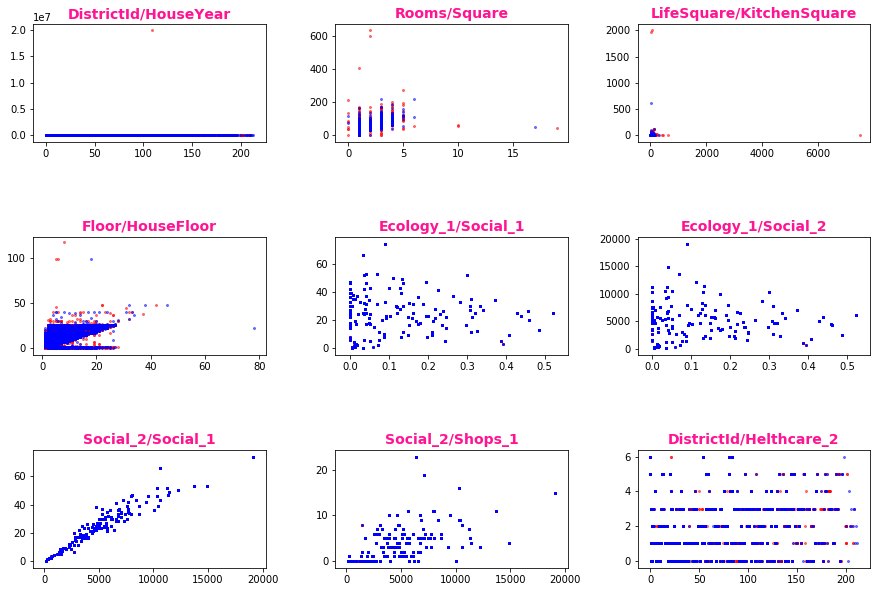

In [15]:
print_first_diagramm(train, test, [[1,0,0,0.5]],[[0,0,1,0.5]],4)

**Результаты первичного анализа данных:**

* 1. В оптимизации хранения данных   нет необходимости, т.к.  объем данных мал. На больших выборках следовало бы привести тип данных к типам данных занимающим минимальный объем памяти, например тип данных признака  Rooms (тип float64) с легкостью можно заменить на тип  integer
* 2. Данные необходимо обработать, т.к. в строках имеются значения NULL и несколько столбцов содержат не числовые значения
* 3. **Ввиду того, что признак  Healthcare_1  имеет значения  NULL на почти половине выборке (как test, так и  train) - отбросим данный столбец при обучении и предсказании**
* 4. Для столбца LifeSquare, KitchenSquare   выполним вычисления и дозаполним вычисленными данными. 
* 5. Высокая кореляция между признаками Social, Shops_1, Ecology_1 для тестовой и обучающей выборки
* 6. Аномально высокое значение HouseYear, LifeSquare, KitchenSquare, Rooms,  Square, HouseFloor, Floor, видны 0-е значения
* 7. Видны ограничения Rooms (<6), HouseFloor (около 100), Floor (около 80) и другие

In [16]:
# ВВедем некоторые ограничения на данные на основе первичного анализа обучающего и тестового набора
S_max = 230
S_min = 22
S_life_max = 220
S_kitch_max  = 60   # Loft ???
S_kitch_norm  = 12 
S_kitch_min  = 12
Price_for_S_max = 12000
S_no_life = 12
sr= train['LifeSquare']/train['Rooms']
S_room = sr.median()
print(S_room)
S_room_min= 7
MaxSfor2Room = 90
Max_Year= 2020
Room_max = 6
MaxHouseFloor=50


17.482665628037864


In [17]:
#t = np.round((train['Square']-S_no_life-S_kitch_norm -train['KitchenSquare'])/ S_room,decimals=0)
#print()
#train['gg'] = np.where(t==0, 1 ,t)
#train[['gg','Rooms']]
#i=train.loc[(train['Rooms'] >Room_max)].index
#t[i]
test.loc[(test['Rooms'] <= 2) & (test['Square'] > MaxSfor2Room)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
499,16274,113,1.0,103.763434,104.926922,1.0,21,20.0,2014,0.050756,B,B,24,5469,1,145.0,0,1,B
830,15096,30,1.0,132.670513,122.578932,3.0,10,39.0,2010,0.000078,B,B,22,6398,141,1046.0,3,23,B
870,13736,27,1.0,141.540215,91.704806,42.0,3,3.0,2013,0.014073,B,B,2,475,0,NaN,0,0,B
1240,9638,27,1.0,98.283783,85.531172,0.0,2,13.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B
1335,3390,72,1.0,101.525664,5.766312,1.0,25,1.0,2017,0.210473,B,B,11,2398,2,1994.0,3,0,B
1447,1968,27,2.0,138.039182,92.484098,42.0,3,3.0,2016,0.014073,B,B,2,475,0,NaN,0,0,B
1536,16123,30,2.0,96.036448,NaN,1.0,4,17.0,2016,0.000078,B,B,22,6398,141,1046.0,3,23,B
1695,10761,52,2.0,95.966073,48.577214,15.0,25,25.0,2009,0.371149,B,B,34,7065,1,750.0,2,5,B
1961,16228,17,1.0,121.453559,87.521642,17.0,17,22.0,2013,0.000000,B,B,18,3374,5,620.0,1,2,B
2213,4530,23,2.0,92.181940,49.502352,15.0,3,25.0,2013,0.075779,B,B,6,1437,3,NaN,0,2,B


# Первичная локализация аномальных значений признаков

## HouseYear

In [18]:
train.loc[train['Id'] == 10814,'HouseYear'] = 2008   # Исправим аномалию HouseYear на бучающем наборе
train.loc[train['Id'] == 11607,'HouseYear'] = 1968

In [19]:
test.loc[test['HouseYear'] > Max_Year]   # Проверим аномалию HouseYear на тестовом наборе

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2


In [20]:
train=df_recalc_sign0(train, 'train', 'HouseYear', train['HouseYear'].median())  # Уберем 0 значения в обучающем наборе

Количество замен значения  0 признака " HouseYear " в датафрейме  train  на  медианное значение  1977.0  =  0


In [21]:
test=df_recalc_sign0(test, 'test', 'HouseYear', train['HouseYear'].median())  # Уберем 0 значения в тестовом наборе

Количество замен значения  0 признака " HouseYear " в датафрейме  test  на  медианное значение  1977.0  =  0


## Square

In [22]:
print('Максимальная   площадь:', S_max)

Максимальная   площадь: 230


In [23]:
# Рассматривая данные о стоимости квартир предполагаем, что в поле LifeSquare могли быть введены данные Square, при этом данные 
# Square - опущены или не верны. Внесем очевидное исправление:
train.loc[train['Square'] < train['LifeSquare'], 'Square'] =  train['LifeSquare'] # Не может быть LifeSquare  больше Square
test.loc[test['Square'] < test['LifeSquare'], 'Square'] =  test['LifeSquare'] # Не может быть LifeSquare  больше Square

In [24]:
train.loc[train['Square'] > S_max]  # Проверим анамалию Square на обучающем наборе

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
590,14990,23,2.0,263.542020,263.542020,5.0,6,5.0,1972.0,0.075779,B,B,6,1437,3,NaN,0,2,B,141780.231857
1982,5548,86,5.0,275.645284,233.949309,26.0,12,37.0,2011.0,0.161976,B,A,31,7010,5,4508.0,3,7,B,455264.882666
4262,28,9,2.0,604.705972,NaN,1.0,17,18.0,1977.0,0.161532,B,B,25,5648,1,30.0,2,4,B,187717.242538
4328,16550,27,3.0,7480.592129,7480.592129,1.0,9,17.0,2016.0,0.017647,B,B,2,469,0,NaN,0,0,B,217357.492366
4690,2307,102,1.0,410.639749,410.639749,10.0,4,4.0,2016.0,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.430830
6977,11602,30,2.0,641.065193,638.163193,10.0,20,19.0,2019.0,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.681562
8437,15886,85,3.0,461.463614,461.463614,10.0,12,16.0,1998.0,0.037178,B,B,52,11217,1,2300.0,1,7,B,394253.299978


In [25]:
train=train.drop(train[train['Id'] == 5548].index)   # Значение не требуется для обучения, 
train=train.drop(train[train['Id'] == 14990].index)  # данных для корректировки не достаточно

train.loc[train['Id'] == 28,'Square'] = 60.4705972  # Приведем в соответствие с  ценой
train.loc[train['Id'] == 16550,'Square'] = 74.80592129 # Приведем в соответствие с  ценой
train.loc[train['Id'] == 2307,'Square'] = 41.0639749 # Приведем в соответствие с  ценой
train.loc[train['Id'] == 11602,'Square'] = 64.1065193 # Приведем в соответствие с  ценой
train.loc[train['Id'] == 15886,'Square'] = 46.1463614 # Приведем в соответствие с  ценой

In [26]:
test.loc[test['Square'] > S_max]  # Проверка на тестовом наборе 

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
410,11533,94,2.0,303.071094,303.071094,6.0,5,12.0,1974.0,0.521867,B,B,25,6149,0,NaN,0,0,B


In [27]:
test.loc[test['Id'] == 11533,'Square'] = 30.3071094 # Приведем в соответствие 

In [28]:
train.loc[train['Square'] > S_max] # Проверим

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [29]:
train=df_recalc_sign0(train, 'train', 'Square', train['Square'].median())  # Уберем 0 значения в обучающем наборе

Количество замен значения  0 признака " Square " в датафрейме  train  на  медианное значение  52.60948952801195  =  0


In [30]:
test=df_recalc_sign0(test, 'test', 'Square', test['Square'].median())  # Уберем 0 значения в обучающем наборе

Количество замен значения  0 признака " Square " в датафрейме  test  на  медианное значение  52.93054962682693  =  0


## Rooms

In [31]:
print('Максимальноя число комнат:', Room_max)

Максимальноя число комнат: 6


In [32]:
train.loc[train['Rooms'] >= Room_max]  # Проверим анамалию Rooms

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
377,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002.0,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.323792
1454,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014.0,0.007122,B,B,1,264,0,NaN,0,1,B,78364.616704
2170,14003,99,6.0,59.414334,38.702244,6.0,7,9.0,1969.0,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.964416
8849,14865,9,10.0,60.871266,38.420681,10.0,3,2.0,1994.0,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.270863


In [33]:
train.loc[train['Id'] == 5927,'Rooms'] = 2  # Приведем в соответствие с площадью
train.loc[train['Id'] == 8491,'Rooms'] = 1 # Приведем в соответствие с площадью
train.loc[train['Id'] == 14003,'Rooms'] = 2 # Приведем в соответствие с площадью
train.loc[train['Id'] == 14865,'Rooms'] = 2 # Приведем в соответствие с площадью

In [34]:
train.loc[train['Rooms'] >= Room_max]  # Проверим анамалию Rooms

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [35]:
test.loc[test['Rooms'] >= Room_max]  # Проверим анамалию Rooms

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
2071,10793,23,6.0,110.750226,NaN,0.0,2,2.0,2015.0,0.014073,B,B,2,475,0,NaN,0,0,B
3217,4058,27,6.0,223.453689,104.113552,16.0,2,2.0,2017.0,0.041116,B,B,53,14892,4,NaN,1,4,B
3398,1435,111,17.0,52.866107,32.528342,8.0,15,17.0,1987.0,0.093443,B,B,23,4635,5,3300.0,2,4,B


In [36]:
test.loc[test['Rooms'] >= Room_max]  # Проверим анамалию Rooms

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
2071,10793,23,6.0,110.750226,NaN,0.0,2,2.0,2015.0,0.014073,B,B,2,475,0,NaN,0,0,B
3217,4058,27,6.0,223.453689,104.113552,16.0,2,2.0,2017.0,0.041116,B,B,53,14892,4,NaN,1,4,B
3398,1435,111,17.0,52.866107,32.528342,8.0,15,17.0,1987.0,0.093443,B,B,23,4635,5,3300.0,2,4,B


In [37]:
test.loc[test['Id'] == 1435,'Rooms'] = 2 # Приведем в соответствие с площадью

In [38]:
train=df_recalc_sign0(train, 'train', 'Rooms', train['Rooms'].median())  # Уберем 0 значения в обучающем наборе

Количество замен значения  0 признака " Rooms " в датафрейме  train  на  медианное значение  2.0  =  8


In [39]:
test=df_recalc_sign0(test, 'test', 'Rooms', train['Rooms'].median())  # Уберем 0 значения в тестовом наборе

Количество замен значения  0 признака " Rooms " в датафрейме  test  на  медианное значение  2.0  =  2


## LifeSquare

In [40]:
print('Максимальная жилая  площадь:', S_life_max)

Максимальная жилая  площадь: 220


In [41]:
train.loc[train['LifeSquare'] > S_life_max]  # Проверим анамалию LifeSquare

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
4328,16550,27,3.0,74.805921,7480.592129,1.0,9,17.0,2016.0,0.017647,B,B,2,469,0,NaN,0,0,B,217357.492366
4690,2307,102,1.0,41.063975,410.639749,10.0,4,4.0,2016.0,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.430830
6977,11602,30,2.0,64.106519,638.163193,10.0,20,19.0,2019.0,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.681562
8437,15886,85,3.0,46.146361,461.463614,10.0,12,16.0,1998.0,0.037178,B,B,52,11217,1,2300.0,1,7,B,394253.299978


In [42]:
train.loc[train['Id'] == 16550,'LifeSquare'] = 74.80592129  # # Приведем в соответствие с  ценой
train.loc[train['Id'] == 2307,'LifeSquare'] = 41.0639749    # * 
train.loc[train['Id'] == 11602,'LifeSquare'] = 63.8163193   # * 
train.loc[train['Id'] == 15886,'LifeSquare'] = 46.1463614   # *

In [43]:
test.loc[test['LifeSquare'] > S_life_max]  # Проверим анамалию LifeSquare в теством наборе

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
410,11533,94,2.0,30.307109,303.071094,6.0,5,12.0,1974.0,0.521867,B,B,25,6149,0,NaN,0,0,B


In [44]:
test.loc[test['Id'] == 11533,'LifeSquare'] = 30.3071094   # Приведем в соответствие с  Square.

In [45]:
(train['LifeSquare'] ==0).value_counts() # Проверим анамалию LifeSquare =0

False    9998
Name: LifeSquare, dtype: int64

In [46]:
(test['LifeSquare'] ==0).value_counts() # Проверим анамалию LifeSquare =0

False    5000
Name: LifeSquare, dtype: int64

## KitchenSquare

In [47]:
print('Максимальная площадь кухни:', S_kitch_max)

Максимальная площадь кухни: 60


In [48]:
train.loc[train['KitchenSquare'] > S_kitch_max]  # Проверим анамалию KitchenSquare 

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
227,16395,2,3.0,79.722243,44.731219,72.0,12,16.0,1987.0,0.130618,B,B,39,10418,9,900.0,1,9,B,370148.625285
1064,14656,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014.0,0.072158,B,B,2,629,1,NaN,0,0,A,108337.484207
1369,2371,27,2.0,68.841073,64.234956,66.0,4,2.0,2014.0,0.017647,B,B,2,469,0,NaN,0,0,B,189244.249909
1455,12507,54,2.0,79.810535,79.578961,78.0,10,15.0,2014.0,0.006076,B,B,30,5285,0,645.0,6,6,B,438708.707579
2916,12390,72,3.0,99.323558,99.323558,96.0,22,25.0,2019.0,0.210473,B,B,11,2398,2,1994.0,3,0,B,445074.956552
2969,7441,62,3.0,114.734473,112.589083,112.0,3,3.0,2015.0,0.072158,B,B,2,629,1,NaN,0,0,A,315245.521059
4079,6508,23,2.0,67.146049,33.959154,63.0,5,17.0,2019.0,0.034656,B,B,0,168,0,NaN,0,0,B,193130.585871
4651,12552,58,3.0,116.405693,113.109653,112.0,3,3.0,2016.0,0.437885,B,B,23,5735,3,1084.0,0,5,B,296165.936689
5149,13703,42,1.0,38.071692,19.723548,73.0,9,10.0,2006.0,0.158249,B,B,21,5731,0,NaN,1,0,B,160488.033165
5888,16593,52,2.0,64.859242,NaN,62.0,15,17.0,1977.0,0.371149,B,B,34,7065,1,750.0,2,5,B,185993.474671


In [49]:
#Т.к. для всех представленных в наборе квартир Square > LifeSquare и представляет  величину соотносящуюся с 
#реальностью вычислим KitchenSquare =  0.125*Square
train.loc[train['KitchenSquare'] > S_kitch_max, 'KitchenSquare']=0.125*train['Square']

In [50]:
test.loc[test['KitchenSquare'] > S_kitch_max]  # Проверим анамалию KitchenSquare   на тестовом наборе

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
40,5428,27,2.0,62.326044,NaN,61.0,12,17.0,1977.0,0.072158,B,B,2,629,1,NaN,0,0,A
1456,5260,73,3.0,69.358242,51.247581,65.0,6,6.0,1931.0,0.042032,B,B,37,6856,84,1940.0,2,5,B
1777,3341,62,3.0,112.247841,112.247841,112.0,3,3.0,2017.0,0.072158,B,B,2,629,1,NaN,0,0,A
1964,14594,11,2.0,42.795304,24.223770,620.0,11,14.0,1972.0,0.038693,B,B,28,6533,1,1015.0,2,5,B
4281,8015,27,1.0,66.099096,33.639611,62.0,3,7.0,2016.0,0.014058,B,B,1,290,0,NaN,0,0,B
4555,12640,6,2.0,54.629142,31.486308,97.0,4,17.0,2015.0,0.243205,B,B,5,1564,0,540.0,0,0,B


In [51]:
#Т.к. для всех представленных в наборе квартир Square > LifeSquare и представляет  величину соотносящуюся с 
#реальностью вычислим KitchenSquare =  0.125*Square
test.loc[test['KitchenSquare'] > S_kitch_max, 'KitchenSquare']=0.125*test['Square']

In [52]:
(train['KitchenSquare'] ==0).value_counts() # Проверим анамалию KitchenSquare =0

False    9301
True      697
Name: KitchenSquare, dtype: int64

In [53]:
(test['KitchenSquare'] ==0).value_counts() # Проверим анамалию KitchenSquare =0

False    4665
True      335
Name: KitchenSquare, dtype: int64

 **Откорректируем  0 значения позже**

## HouseFloor

In [54]:
print('Максимальная этажность :', MaxHouseFloor)

Максимальная этажность : 50


In [55]:
train.loc[train['HouseFloor'] > MaxHouseFloor]  # Проверим анамалию HouseFloor

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
6131,10806,5,1.0,51.944587,48.709601,1.0,6,99.0,1977.0,0.150818,B,B,16,3433,4,2643.0,4,5,B,296127.115515
8599,9300,74,2.0,74.579809,74.579809,9.0,5,99.0,1977.0,0.075779,B,B,6,1437,3,NaN,0,2,B,243329.912579
8854,78,30,2.0,66.811789,66.811789,1.0,8,117.0,1977.0,0.000078,B,B,22,6398,141,1046.0,3,23,B,207248.370520


In [56]:
test.loc[test['HouseFloor'] > MaxHouseFloor]  # Проверим анамалию HouseFloor на тестовом наборе

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
651,15864,27,3.0,47.722835,47.098813,9.0,18,99.0,1977.0,0.072158,B,B,2,629,1,NaN,0,0,A


In [57]:
test=df_recalc_sign0(test, 'test', 'HouseFloor', train['HouseFloor'].median())  # Уберем 0 значения в тестовом наборе

Количество замен значения  0 признака " HouseFloor " в датафрейме  test  на  медианное значение  13.0  =  131


In [58]:
# Маловероятно, что в 1977 году были здания с 99 или 117 этажами. Меняем на 9 и 17 соответственно
train.loc[train['Id'] == 10806,'HouseFloor'] = 9   # Приведем в соответствие 
train.loc[train['Id'] == 9300,'HouseFloor'] = 9   # *
train.loc[train['Id'] == 78,'HouseFloor'] = 17      # *
test.loc[test['Id'] == 15864,'HouseFloor'] = 9     # *

In [59]:
train=df_recalc_sign0(train, 'train', 'HouseFloor', train['HouseFloor'].median())  # Уберем 0 значения в обучающем наборе
test=df_recalc_sign0(test, 'test', 'HouseFloor', train['HouseFloor'].median())  # Уберем 0 значения в тестовом наборе

Количество замен значения  0 признака " HouseFloor " в датафрейме  train  на  медианное значение  13.0  =  269
Количество замен значения  0 признака " HouseFloor " в датафрейме  test  на  медианное значение  13.0  =  0


In [60]:
train.loc[train['HouseFloor'] > MaxHouseFloor]  # Проверим

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


## Floor

In [61]:
print('Максимальная этажность :', MaxHouseFloor)

Максимальная этажность : 50


In [62]:
train.loc[train['Floor'] > MaxHouseFloor]  # Проверим анамалию Floor

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [63]:
# На обучающем наборе аномалии нет

In [64]:
train.loc[train['Floor'] > train['HouseFloor']].head()  # Проверим анамалию Floor > HouseFloor

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
7,11993,74,2.0,80.312926,NaN,0.0,14,13.0,1977.0,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156664
14,10953,27,1.0,53.769097,52.408027,1.0,5,4.0,1977.0,0.072158,B,B,2,629,1,NaN,0,0,A,140647.565937
16,2119,27,2.0,49.360648,31.993964,5.0,6,5.0,1983.0,0.051815,B,B,5,1227,0,NaN,0,0,B,117000.381287
21,11935,27,2.0,64.711835,NaN,1.0,15,1.0,1977.0,0.211401,B,B,9,1892,0,NaN,0,1,B,127200.026511
26,4378,27,3.0,106.958871,0.641822,0.0,17,13.0,2018.0,0.072158,B,B,2,629,1,NaN,0,0,A,337299.867936


**Анализ аномалии выявил типичную ошибку. Необходимо значения Floor и HouseFloor  поменять между собой**

In [65]:
floor_outliers = train.loc[train['Floor'] > train['HouseFloor']].index

floor_temp = train.loc[train['Floor'] > train['HouseFloor']]['Floor']

train.loc[floor_outliers, 'Floor'] =train.loc[floor_outliers, 'HouseFloor']

train.loc[floor_outliers, 'HouseFloor'] =floor_temp

In [66]:
train.loc[floor_outliers].head()  # Проверим

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
7,11993,74,2.0,80.312926,NaN,0.0,13.0,14.0,1977.0,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156664
14,10953,27,1.0,53.769097,52.408027,1.0,4.0,5.0,1977.0,0.072158,B,B,2,629,1,NaN,0,0,A,140647.565937
16,2119,27,2.0,49.360648,31.993964,5.0,5.0,6.0,1983.0,0.051815,B,B,5,1227,0,NaN,0,0,B,117000.381287
21,11935,27,2.0,64.711835,NaN,1.0,1.0,15.0,1977.0,0.211401,B,B,9,1892,0,NaN,0,1,B,127200.026511
26,4378,27,3.0,106.958871,0.641822,0.0,13.0,17.0,2018.0,0.072158,B,B,2,629,1,NaN,0,0,A,337299.867936


In [67]:
test.loc[test['Floor'] > MaxHouseFloor]  # Проверим анамалию Floor на тестовом наборе данных

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4698,15759,17,2.0,57.60187,37.744743,10.0,78,22.0,1989.0,0.0,B,B,25,5027,4,46.0,1,1,B


In [68]:
test.loc[test['Id'] == 15759,'Floor'] = 18      # Одна аномалия. Предполагаем опечатку символ 1 на символ 7 

In [69]:
test.loc[test['Floor'] > test['HouseFloor']].head(10)  # Проверим анамалию Floor > HouseFloor

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977.0,0.075779,B,B,6,1437,3,NaN,0,2,B
10,15975,61,3.0,64.543658,42.651541,7.0,10,9.0,1981.0,0.300323,B,B,52,10311,6,NaN,1,9,B
14,5214,27,1.0,37.555197,NaN,1.0,5,1.0,1977.0,0.211401,B,B,9,1892,0,NaN,0,1,B
27,11160,58,1.0,48.752502,48.752502,1.0,4,3.0,1977.0,0.437885,B,B,23,5735,3,1084.0,0,5,B
32,2449,1,1.0,66.426585,NaN,0.0,14,13.0,1977.0,0.007122,B,B,1,264,0,NaN,0,1,B
36,9348,205,1.0,37.480811,16.851795,8.0,6,5.0,1933.0,0.169091,B,B,19,3856,10,NaN,2,5,B
41,12749,21,2.0,49.011976,27.980195,5.0,6,5.0,1969.0,0.194489,B,B,47,8004,3,125.0,3,5,B
46,12309,45,1.0,42.899569,NaN,0.0,25,13.0,1977.0,0.195781,B,B,23,5212,6,NaN,3,2,B
55,5452,27,1.0,48.587913,42.596190,12.0,3,2.0,2016.0,0.017647,B,B,2,469,0,NaN,0,0,B
58,2831,21,1.0,21.452899,15.798509,3.0,11,9.0,1972.0,0.194489,B,B,47,8004,3,125.0,3,5,B


In [70]:
floor_outliers = test.loc[test['Floor'] > test['HouseFloor']].index
floor_temp = test.loc[test['Floor'] > test['HouseFloor']]['Floor']
test.loc[floor_outliers, 'Floor'] =test.loc[floor_outliers, 'HouseFloor']
test.loc[floor_outliers, 'HouseFloor'] =floor_temp
test.loc[floor_outliers].head()  # Проверим

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
1,15856,74,2.0,69.263183,NaN,1.0,1.0,6.0,1977.0,0.075779,B,B,6,1437,3,NaN,0,2,B
10,15975,61,3.0,64.543658,42.651541,7.0,9.0,10.0,1981.0,0.300323,B,B,52,10311,6,NaN,1,9,B
14,5214,27,1.0,37.555197,NaN,1.0,1.0,5.0,1977.0,0.211401,B,B,9,1892,0,NaN,0,1,B
27,11160,58,1.0,48.752502,48.752502,1.0,3.0,4.0,1977.0,0.437885,B,B,23,5735,3,1084.0,0,5,B
32,2449,1,1.0,66.426585,NaN,0.0,13.0,14.0,1977.0,0.007122,B,B,1,264,0,NaN,0,1,B


In [71]:
train=df_recalc_sign0(train, 'train', 'Floor', train['Floor'].median())  # Уберем 0 значения в обучающем наборе
test=df_recalc_sign0(test, 'test', 'Floor', train['Floor'].median())  # Уберем 0 значения в тестовом наборе

Количество замен значения  0 признака " Floor " в датафрейме  train  на  медианное значение  7.0  =  0
Количество замен значения  0 признака " Floor " в датафрейме  test  на  медианное значение  7.0  =  0


In [72]:
#train.loc[train['Floor'] > train['HouseFloor'], 'Floor'] =  train['HouseFloor'] # Этаж не может быть выше количества этажей дома
#test.loc[test['Floor'] > test['HouseFloor'], 'Floor'] =  test['HouseFloor']

## DistrictId

In [73]:
train['DistrictId'].unique()

array([ 35,  41,  53,  58,  99,  59, 154,  74,   1,  23,  28,  31,  13,
        57,  27,  85,  34,  19,   0,  48,  54, 150,  11,  50,  61,  44,
        90, 200,  43, 177, 101,  38,  21, 103,  98, 170,  94,   5,  88,
        47,   6,  52,  62,  77,  79,   9, 156,  69, 108,  96, 169,  18,
       148, 128,  10, 144, 120,  39,   7,  84, 123, 159,  70, 129,   3,
        95,  78,  45,  15, 121,  49,  25,   2, 127,  56, 109,  46,  17,
       119,  80,  86,  83, 137,  91,  92, 118, 187,  36, 106, 161,  22,
        63, 167, 113,  66,  29,  37,  20,   8, 181,  40,  93,  30,  81,
       107, 130, 100,  12, 125,  67,  26,  89,  24, 111, 138,  64, 124,
       183,  55, 157, 151,  33,  87, 126, 155, 164, 105, 110, 132,  71,
        73, 189,  75, 122, 163, 141,  76, 115, 139, 143, 201, 165, 190,
       193, 174,  60, 114, 172, 134, 117, 149, 153, 131, 145,  82, 160,
        42,  32, 133, 208, 171, 176, 173, 147,  97, 142, 195, 180, 196,
       112,  72, 175,   4, 186, 146, 191, 168, 192,  14, 199, 13

In [74]:
district_size = train['DistrictId'].value_counts().reset_index()\
                .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size['DistrictSize'].unique()

array([851, 652, 564, 511, 294, 247, 228, 179, 174, 165, 143, 142, 129,
       119, 118, 116, 114, 111, 107, 104,  97,  92,  90,  89,  87,  82,
        80,  79,  78,  77,  76,  73,  72,  71,  67,  66,  65,  64,  62,
        61,  59,  58,  57,  56,  55,  51,  49,  48,  46,  44,  43,  42,
        41,  40,  37,  36,  35,  34,  33,  32,  31,  29,  28,  27,  26,
        25,  24,  23,  22,  21,  20,  19,  18,  17,  16,  15,  14,  13,
        12,  11,  10,   9,   8,   7,   6,   5,   4,   3,   2,   1],
      dtype=int64)

In [75]:
avgD= train.groupby('DistrictId').sum()
avgD.head(5)

,Id,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
DistrictId,,,,,,,,,,,,,,,,
0,398543,85.0,2618.394574,1459.140938,346.00000,319.0,589.0,95295.0,10.017385,1285,237281,496,99532.0,257,350,9.374188e+06
1,5297316,1176.0,38755.903993,12085.546712,1784.00000,6570.0,11281.0,1294456.0,5.988941,2063,398514,26,13040.0,139,646,1.224491e+08
2,661708,149.0,4204.249614,2551.215415,585.96528,495.0,839.0,154184.0,10.733812,2875,666317,318,84680.0,54,446,1.900771e+07
3,660031,144.0,4111.345762,2512.560044,599.00000,619.0,1011.0,162327.0,9.723652,3355,730127,60,52820.0,190,221,1.475221e+07
4,116415,26.0,735.052445,485.177841,84.00000,58.0,108.0,21669.0,2.088359,227,46984,672,22912.0,18,61,3.301064e+06


In [76]:
avgD['avgPbSD']= avgD['Price']/avgD['Square']/10   # масштабируем среднюю стоимость по району в 10 раз
avgD.head(5)

,Id,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,avgPbSD
DistrictId,,,,,,,,,,,,,,,,,
0,398543,85.0,2618.394574,1459.140938,346.00000,319.0,589.0,95295.0,10.017385,1285,237281,496,99532.0,257,350,9.374188e+06,358.012823
1,5297316,1176.0,38755.903993,12085.546712,1784.00000,6570.0,11281.0,1294456.0,5.988941,2063,398514,26,13040.0,139,646,1.224491e+08,315.949596
2,661708,149.0,4204.249614,2551.215415,585.96528,495.0,839.0,154184.0,10.733812,2875,666317,318,84680.0,54,446,1.900771e+07,452.107129
3,660031,144.0,4111.345762,2512.560044,599.00000,619.0,1011.0,162327.0,9.723652,3355,730127,60,52820.0,190,221,1.475221e+07,358.817093
4,116415,26.0,735.052445,485.177841,84.00000,58.0,108.0,21669.0,2.088359,227,46984,672,22912.0,18,61,3.301064e+06,449.092250


Text(0.5, 1.0, 'Распределение  DistrictId и средняя цена по району(*10)')

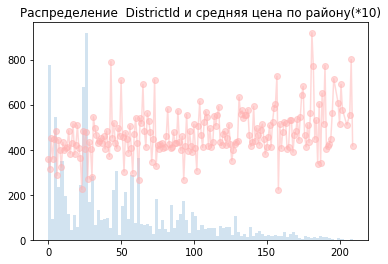

In [77]:
plt.hist(train['DistrictId'], bins = 100, alpha = 0.2, label ='Районы' )
plt.plot( avgD.index, avgD['avgPbSD'], marker = 'o', c=[1,0.7,0.7,0.5], label ='Средняя цена')
plt.title('Распределение  DistrictId и средняя цена по району(*10)')
#plt.legend()

In [78]:
train = train.merge(district_size, on='DistrictId', how='left')
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize
0,14038,35,2.0,47.981561,29.442751,6.0,7.0,9.0,1969.0,0.089040,...,B,33,7976,5,NaN,0,11,B,184966.930730,22
1,15053,41,3.0,65.683640,40.049543,8.0,7.0,9.0,1978.0,0.000070,...,B,46,10309,1,240.0,1,16,B,300009.450063,87
2,4765,53,2.0,44.947953,29.197612,0.0,8.0,12.0,1968.0,0.049637,...,B,34,7759,0,229.0,1,3,B,220925.908524,174
3,5809,58,2.0,53.352981,52.731512,9.0,8.0,17.0,1977.0,0.437885,...,B,23,5735,3,1084.0,0,5,B,175616.227217,179
4,10783,99,1.0,39.649192,23.776169,7.0,11.0,12.0,1976.0,0.012339,...,B,35,5776,1,2078.0,2,4,B,150226.531644,97


In [79]:
(train['DistrictSize'] > 100).value_counts()

True     5068
False    4930
Name: DistrictSize, dtype: int64

In [80]:
train['IsDistrictLarge'] = (train['DistrictSize'] > 100).astype(int) # создадим признак IsDistrictLarge

In [81]:
district_size_test = test['DistrictId'].value_counts().reset_index()\
                .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})


In [82]:
test = test.merge(district_size_test, on='DistrictId', how='left')
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,DistrictSize
0,725,58,2.0,49.882643,33.432782,6.0,6.0,14.0,1972.0,0.310199,B,B,11,2748,1,NaN,0,0,B,91
1,15856,74,2.0,69.263183,NaN,1.0,1.0,6.0,1977.0,0.075779,B,B,6,1437,3,NaN,0,2,B,61
2,5480,190,1.0,15.948246,15.948246,12.0,2.0,5.0,1909.0,0.000000,B,B,30,7538,87,4702.0,5,5,B,2
3,15664,47,2.0,73.046609,51.940842,9.0,22.0,22.0,2007.0,0.101872,B,B,23,4583,3,NaN,3,3,B,49
4,14275,27,1.0,47.527111,43.387569,1.0,17.0,17.0,2017.0,0.072158,B,B,2,629,1,NaN,0,0,A,391


# Повторно изучим диаграммы

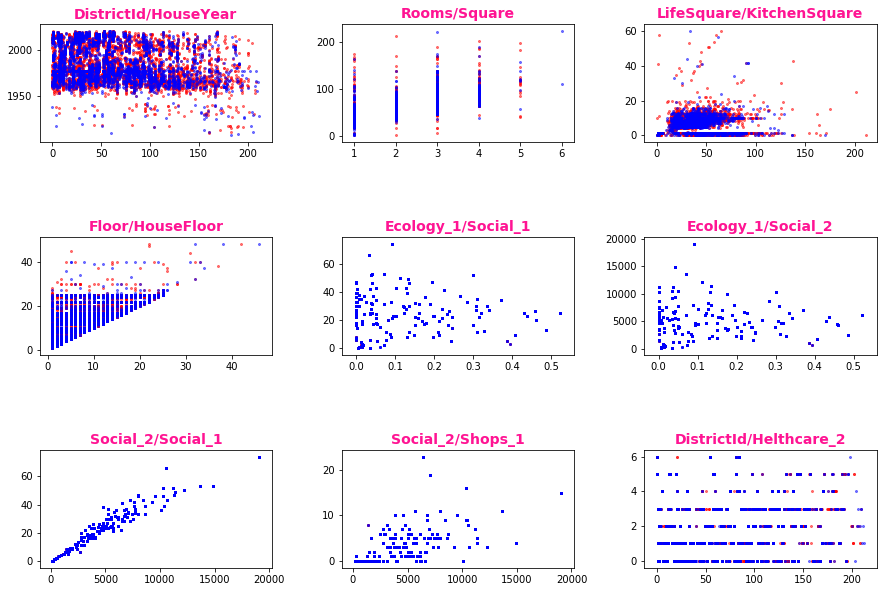

In [83]:
print_first_diagramm(train, test, [[1,0,0,0.5]],[[0,0,1,0.5]],4)

# Исследование показало:
1. Наличие значительного количества объектов, где Square и  LifeSquare при числе комнат 1, 2,  более 100 кв. м. Необходимо исследовать данные.
2. Присутствуют 0 значения площадей
3. Имеются объекты, где при числе комнат более 5 площадь менее 50 кв. м. Необходимо исследовать данные.
4. Зависимость Floor/HouseFloor  имеет близкую к правильной организацию
5. Обучающий набор "уже", например по признаку Rooms, чем тестовый набор

# Повторно  исследуем Square и Rooms

In [84]:
train.loc[train['Rooms'] >= 5]  # Проверим анамалию Square/Rooms>5

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,IsDistrictLarge
1421,4282,195,5.0,95.617533,62.377052,7.0,7.0,7.0,1940.0,0.015017,...,17,3079,59,2890.0,0,8,B,479525.147323,2,0
1502,1243,86,5.0,108.057398,82.723825,8.0,3.0,5.0,1942.0,0.161976,...,31,7010,5,4508.0,3,7,B,310305.074733,26,0
3266,8901,34,5.0,121.577423,114.913843,1.0,1.0,25.0,1977.0,0.069753,...,53,13670,4,NaN,1,11,B,455446.393758,111,1
3269,6358,27,5.0,42.003293,NaN,0.0,5.0,12.0,1977.0,0.011654,...,4,915,0,NaN,0,0,B,112693.641769,851,1
4429,7594,53,5.0,39.906082,39.394024,1.0,1.0,5.0,1977.0,0.049637,...,34,7759,0,229.0,1,3,B,206148.845716,174,1
4485,13434,13,5.0,183.382273,100.985505,15.0,2.0,6.0,1997.0,0.090799,...,74,19083,2,NaN,5,15,B,622888.825328,97,0
4760,4070,21,5.0,114.313752,88.492650,9.0,5.0,6.0,1960.0,0.034331,...,25,5487,3,NaN,0,4,B,499830.937577,165,1
5359,2879,78,5.0,118.871952,69.023509,10.0,15.0,16.0,1998.0,0.092291,...,21,4346,2,165.0,1,2,B,496026.671162,46,0
5464,3454,8,5.0,112.135525,79.795451,10.0,4.0,17.0,1999.0,0.437885,...,23,5735,3,1084.0,0,5,B,471833.787538,142,1
6621,3294,167,5.0,111.045799,81.940459,9.0,6.0,6.0,1940.0,0.050272,...,21,4231,14,1020.0,0,3,B,513239.499082,20,0


In [85]:
train.loc[train['Id'] == 6358,'Rooms'] = 1   # Приведем в соответствие
train.loc[train['Id'] == 7594,'Rooms'] = 1   # Приведем в соответствие

In [86]:
test.loc[test['Rooms'] >= 5]  # Проверим анамалию Square/Rooms>5 на тестовом  наборе

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,DistrictSize
78,6553,34,5.0,122.375273,0.333490,0.0,9.0,13.0,1977.0,0.069753,B,B,53,13670,4,NaN,1,11,B,61
619,15858,9,5.0,97.537815,63.571997,8.0,5.0,14.0,1995.0,0.136244,B,B,11,2370,0,NaN,0,1,B,132
803,3747,23,5.0,139.045763,89.790274,42.0,1.0,3.0,2015.0,0.014073,B,B,2,475,0,NaN,0,0,B,264
1040,13562,78,5.0,116.656955,69.561006,10.0,5.0,14.0,2001.0,0.219006,B,B,28,6746,3,NaN,1,4,B,21
2071,10793,23,6.0,110.750226,NaN,0.0,2.0,2.0,2015.0,0.014073,B,B,2,475,0,NaN,0,0,B,264
3217,4058,27,6.0,223.453689,104.113552,16.0,2.0,2.0,2017.0,0.041116,B,B,53,14892,4,NaN,1,4,B,391
3253,12316,183,5.0,157.976101,101.040485,12.0,7.0,8.0,1908.0,0.246624,B,B,14,2940,45,NaN,3,6,B,2
3339,8638,25,5.0,120.330727,115.328430,1.0,14.0,25.0,2016.0,0.069753,B,B,53,13670,4,NaN,1,11,B,42
3912,6060,53,5.0,56.600162,2.742068,1.0,6.0,18.0,1977.0,0.049637,B,B,34,7759,0,229.0,1,3,B,91


In [87]:
train.loc[train['Id'] == 6060,'Rooms'] = 2   # Приведем в соответствие

## Введем столбец удельной стоимости

In [88]:
train['price_by_sq']= train['Price']/train['Square']

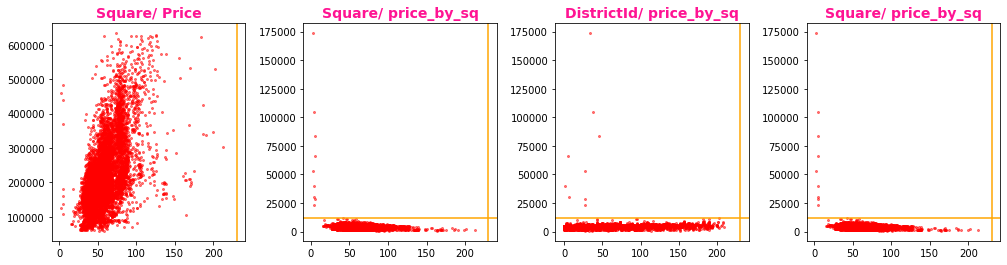

In [89]:
# Посмотрим на диаграммы распределения  цены  от площади, удельной цены от  площади и удельной цены от района
graph_SqbyPr(train, [[1,0,0,0.5]], 4)

### Из представленных диаграмм хорошо видны выбросы данных. Особое внимание следует обратить на значительный скачек удельной стоимости кв.м., что может быть связано с близкими к нулю значениями Square

### Везде, где удельная стоимость выше Price_for_S_max (12000) увеличим Square в 10 раз

In [90]:
train.loc[(train['price_by_sq'] >Price_for_S_max), 'Square']= train['Square']*10
train['price_by_sq']= train['Price']/train['Square']

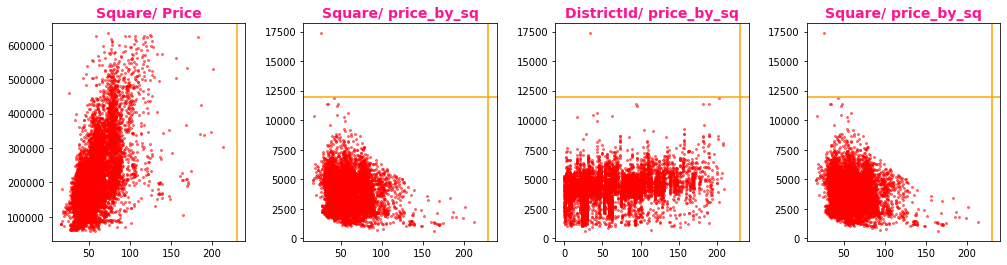

In [91]:
# Посмотрим на диаграммы распределения  цены  от площади, удельной цены от  площади и удельной цены от района еще раз
graph_SqbyPr(train, [[1,0,0,0.5]], 4)

In [92]:
train.loc[(train['price_by_sq'] >Price_for_S_max)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,IsDistrictLarge,price_by_sq
8281,15744,34,1.0,26.422186,2.642219,1.0,4.0,21.0,1977.0,0.069753,...,13670,4,NaN,1,11,B,458378.777006,111,1,17348.253205


In [93]:
# Для изменения записи не достаточно данных. Удалим запись из обучающего набора.
train = train.drop(train[train['price_by_sq']>Price_for_S_max].index)

In [94]:
train.loc[(train['price_by_sq'] >Price_for_S_max)] # проверим

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,IsDistrictLarge,price_by_sq


In [95]:
train['price_by_sq']= train['Price']/train['Square']  # пересчитаем 

In [96]:
print(train['price_by_sq'].max())
print(train['price_by_sq'].median())
print(train['price_by_sq'].min())
avg_price = train.groupby(['DistrictId'])['price_by_sq'].mean().reset_index()
avg_price.columns = ['DistrictId','mean_price_district']
avg_price.head()
train = pd.merge(train, avg_price, how = 'left', on = ['DistrictId'])
#train.head()

11854.652892142012
3905.752081380522
638.9821926124976


### Проанализируем все строки, где price_by_sq меньше 1000 

In [97]:
train.loc[(train['price_by_sq']<= 1000)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,IsDistrictLarge,price_by_sq,mean_price_district
695,7590,113,3.0,94.417148,56.749169,11.0,6.0,18.0,2008.0,0.050756,...,1,145.0,0,1,B,71057.273346,41,0,752.588644,4489.211417
3721,203,33,4.0,101.554252,22.630373,9.0,4.0,5.0,1958.0,0.051942,...,7,800.0,2,0,B,82342.775873,31,0,810.825491,4774.230257
4440,14825,152,3.0,88.978324,56.939045,12.0,7.0,7.0,1958.0,0.042032,...,84,1940.0,2,5,B,85499.969325,7,0,960.907842,5704.809920
6330,8961,27,1.0,164.153360,164.153360,6.0,3.0,5.0,1965.0,0.211401,...,0,NaN,0,1,B,104891.073757,851,1,638.982193,2757.549798
8370,14892,57,3.0,84.206197,49.920840,8.0,7.0,7.0,2005.0,0.090799,...,2,NaN,5,15,B,71319.376419,107,1,846.961137,4083.311445
9748,6627,36,3.0,86.594116,54.695269,10.0,7.0,17.0,2008.0,0.087619,...,5,NaN,1,0,B,85537.735405,17,0,987.800779,4667.009300


## ВАЖНО !!!!

### Для изменения записей не достаточно данных. Рассмотрим удаление этих записей как вариант изменения обучающей выборки далее

In [98]:
train = train.drop(train[train['price_by_sq']<= 1000].index)
#train.loc[(train['price_by_sq']<= 1000)]
train['variant1']=0
train.loc[(train['price_by_sq']<= 1000),'variant1']=1
train.loc[(train['price_by_sq']<= 1000)][['Id','variant1']].head(5)

,Id,variant1


# Продолжим исследование данных

In [99]:
# Рассмотрим записи, из которых следует, что это объекты не предназначенные для жилья (площадь комнат мала)
train.loc[(train['Square']-S_no_life)/train['Rooms'] <= S_room_min][['Id','Rooms',"Square", 'price_by_sq', 'mean_price_district']]

,Id,Rooms,Square,price_by_sq,mean_price_district
1890,13685,1.0,17.498542,5078.808780,3710.401014
3792,523,1.0,18.509177,6258.833718,4177.749766
4737,12676,3.0,15.988889,4902.704907,4518.553693
4851,3224,2.0,23.772476,5325.357884,2757.549798
5615,15877,3.0,16.698571,4661.188520,4083.311445
6943,12927,2.0,17.414181,10379.498777,2811.362686
7765,6927,1.0,16.117154,4958.274052,4084.277065
7895,10635,1.0,18.983962,5921.378211,4084.277065
8146,3052,3.0,31.113950,3688.268791,3202.403882


In [100]:
# Из удельных показателей price_by_sq и mean_price_district видно, что для записи id = 12927 можно 
# откорректировать Square минимум в два раза
train.loc[train['Id'] == 12927,'Square'] = 2* train['Square']
# В обучающем наборе вариант 1 удалим записи (пометим на удаление)
train.loc[(train['Square']-S_no_life)/train['Rooms']<= S_room_min,'variant1']=1

In [101]:
# Откорректируем  количество комнат
train.loc[(train['Square']-S_no_life)/train['Rooms'] <= S_room_min, "Rooms"] = 1

In [102]:
# Рассмотрим записи в тестовом наборе, из которых следует, что это объекты не предназначенные для жилья 
#  (площадь комнат мала)
test.loc[(test['Square']-S_no_life)/test['Rooms'] <= S_room_min]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,DistrictSize
2,5480,190,1.0,15.948246,15.948246,12.0,2.0,5.0,1909.0,0.000000,B,B,30,7538,87,4702.0,5,5,B,2
66,9011,53,1.0,1.378543,1.353573,1.0,1.0,1.0,1977.0,0.049637,B,B,34,7759,0,229.0,1,3,B,91
263,11407,79,4.0,37.920348,21.357487,6.0,6.0,17.0,2014.0,0.307467,B,A,30,5048,9,325.0,2,5,B,24
608,16401,30,1.0,4.338755,4.338755,1.0,1.0,2.0,1977.0,0.000078,B,B,22,6398,141,1046.0,3,23,B,115
837,2138,27,1.0,5.647458,1.501582,1.0,1.0,1.0,1977.0,0.017647,B,B,2,469,0,NaN,0,0,B,391
1165,10120,6,1.0,5.100672,3.861780,1.0,1.0,3.0,1977.0,0.243205,B,B,5,1564,0,540.0,0,0,B,257
1195,3969,101,1.0,18.149267,9.698766,3.0,4.0,5.0,1967.0,0.225825,A,B,41,6558,7,1548.0,3,2,B,46
1441,9884,29,1.0,17.273699,16.452172,2.0,3.0,5.0,1962.0,0.069660,B,B,31,6119,4,NaN,1,2,B,60
2744,7533,66,1.0,16.319015,11.118981,1.0,4.0,5.0,1965.0,0.111627,B,B,50,12238,8,1970.0,2,3,B,27
3697,15435,21,1.0,13.305531,9.495367,0.0,5.0,6.0,1965.0,0.194489,B,B,47,8004,3,125.0,3,5,B,70


In [103]:
# Откорректируем  Square менее 10 кв. м. в 10 раз
test.loc[((test['Square']-S_no_life)/test['Rooms'] <= S_room_min) & (test['Square']<10), "Square"] = test['Square']*10

In [104]:
#Проверим
test.loc[test['Id'] == 7855]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,DistrictSize
4540,7855,6,1.0,49.671431,2.968086,1.0,1.0,3.0,2018.0,0.243205,B,B,5,1564,0,540.0,0,0,B,257


In [105]:
# Проверим анамалию Square 100 / Rooms <=2
temp=train.loc[(train['Rooms'] <= 2) & (train['Square'] > MaxSfor2Room)]
pdim(temp, 'temp')
temp.head(3) 

Dimensions "temp"  (62, 25) <class 'pandas.core.frame.DataFrame'>


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,IsDistrictLarge,price_by_sq,mean_price_district,variant1
136,6172,27,2.0,92.400007,92.069236,10.0,2.0,5.0,1977.0,0.075424,...,NaN,0,0,B,116942.671045,851,1,1265.613229,2757.549798,0
506,9552,23,1.0,106.178175,106.178175,0.0,2.0,3.0,1977.0,0.014073,...,NaN,0,0,B,218718.046451,564,1,2059.915298,2276.523362,0
609,9275,113,1.0,101.737698,74.881315,16.0,23.0,24.0,2019.0,0.050756,...,145.0,0,1,B,396825.943131,41,0,3900.480839,4489.211417,0


In [106]:
# Пересчитаем количество комнат
train.loc[(test['Rooms'] <= 2) & (train['Square'] > MaxSfor2Room), 'Rooms']= np.round((train['Square']
                                    -S_no_life-S_kitch_norm -train['KitchenSquare'])/ S_room,decimals=0) 

In [107]:
#Проверим
train.loc[train['Id'] == 6172]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,IsDistrictLarge,price_by_sq,mean_price_district,variant1
136,6172,27,3.0,92.400007,92.069236,10.0,2.0,5.0,1977.0,0.075424,...,NaN,0,0,B,116942.671045,851,1,1265.613229,2757.549798,0


In [108]:
test.loc[(test['Rooms'] <= 2) & (test['Square'] > MaxSfor2Room)].head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,DistrictSize
499,16274,113,1.0,104.926922,104.926922,1.0,20.0,21.0,2014.0,0.050756,B,B,24,5469,1,145.0,0,1,B,27
830,15096,30,1.0,132.670513,122.578932,3.0,10.0,39.0,2010.0,0.000078,B,B,22,6398,141,1046.0,3,23,B,115
870,13736,27,1.0,141.540215,91.704806,42.0,3.0,3.0,2013.0,0.014073,B,B,2,475,0,NaN,0,0,B,391
1240,9638,27,1.0,98.283783,85.531172,0.0,2.0,13.0,2014.0,0.075424,B,B,11,3097,0,NaN,0,0,B,391
1335,3390,72,1.0,101.525664,5.766312,1.0,1.0,25.0,2017.0,0.210473,B,B,11,2398,2,1994.0,3,0,B,12


In [109]:
test.loc[(test['Rooms'] <= 2) & (test['Square'] > MaxSfor2Room), 'Rooms']= np.round((test['Square']
                                    -S_no_life-S_kitch_norm -test['KitchenSquare'])/ S_room,decimals=0) 

In [110]:
#Проверим
test.loc[test['Id'] == 9638]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,DistrictSize
1240,9638,27,4.0,98.283783,85.531172,0.0,2.0,13.0,2014.0,0.075424,B,B,11,3097,0,NaN,0,0,B,391


In [111]:
# Исследуем объекты площадью более 180
train.loc[(train['Square'] >180)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,IsDistrictLarge,price_by_sq,mean_price_district,variant1
651,3718,56,3.0,190.857689,107.376164,19.0,3.0,7.0,2007.0,0.000000,...,NaN,2,6,B,338644.075979,34,0,1774.327659,5416.762429,0
1980,7917,27,2.0,212.932361,211.231125,0.0,2.0,3.0,2008.0,0.211401,...,NaN,0,1,B,302211.260887,851,1,1419.282909,2757.549798,0
4485,13434,13,5.0,183.382273,100.985505,15.0,2.0,6.0,1997.0,0.090799,...,NaN,5,15,B,622888.825328,97,0,3396.668696,4215.115104,0
5085,15947,129,4.0,185.906396,84.830074,31.0,3.0,5.0,2015.0,0.020741,...,1340.0,2,5,B,340273.238253,43,0,1830.347126,4575.015976,0
7199,3233,129,4.0,186.692602,87.487080,32.0,3.0,3.0,2011.0,0.020741,...,1340.0,2,5,B,423443.464367,43,0,2268.131995,4575.015976,0
8508,4249,23,5.0,198.930182,123.139863,10.0,1.0,2.0,2011.0,0.014073,...,NaN,0,0,B,345665.209100,564,1,1737.620735,2276.523362,0
9907,16568,27,4.0,201.627361,201.627361,25.0,1.0,2.0,2013.0,0.041116,...,NaN,1,4,B,528560.506016,851,1,2621.472123,2757.549798,0


In [112]:
train.loc[(train['Id'] ==3718), 'Rooms'] =4
train.loc[(train['Id'] ==7917), 'Rooms'] =4

In [113]:
test.loc[(test['Square'] >180)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,DistrictSize
1499,7769,124,4.0,189.679576,114.708673,4.0,19.0,40.0,2013.0,0.174739,B,B,17,3379,9,100.0,0,3,B,28
3217,4058,27,6.0,223.453689,104.113552,16.0,2.0,2.0,2017.0,0.041116,B,B,53,14892,4,NaN,1,4,B,391
3909,1397,76,3.0,221.138768,118.055342,4.0,32.0,48.0,2011.0,0.000000,B,B,7,1660,39,1786.0,1,5,B,8


In [114]:
test.loc[(test['Id'] ==1397), 'Rooms'] =5

In [115]:
# Исследуем объекты c числом комнат более 6
train.loc[(train['Rooms'] >6)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,IsDistrictLarge,price_by_sq,mean_price_district,variant1
1354,10263,74,7.0,138.700092,NaN,1.0,2.0,3.0,1977.0,0.309479,...,990.0,0,6,B,195831.983247,114,1,1411.909538,3344.694536,0
1396,12638,27,7.0,138.427694,136.215499,0.0,3.0,4.0,2016.0,0.075424,...,NaN,0,0,B,268394.744389,851,1,1938.880408,2757.549798,0
1640,11055,151,8.0,174.837082,174.837082,15.0,10.0,12.0,1958.0,0.236108,...,NaN,3,10,B,232766.187698,14,0,1331.331918,5150.779266,0
1811,5602,93,8.0,169.385184,NaN,1.0,2.0,10.0,1977.0,0.004949,...,NaN,0,0,B,190949.293998,73,0,1127.308125,3119.445635,0
2601,5621,23,7.0,163.495333,161.504222,12.0,3.0,5.0,1977.0,0.014073,...,NaN,0,0,B,207007.956663,564,1,1266.139848,2276.523362,0
3181,542,23,7.0,138.910187,138.910187,0.0,2.0,13.0,1977.0,0.014073,...,NaN,0,0,B,166687.735824,564,1,1199.967685,2276.523362,0
3649,5300,30,8.0,170.713651,170.713651,1.0,2.0,2.0,2018.0,0.000078,...,1046.0,3,23,B,200800.673767,228,1,1176.242631,2838.676513,0
4914,4450,56,7.0,138.995003,NaN,1.0,1.0,16.0,1977.0,0.000000,...,NaN,2,6,B,571939.918111,34,0,4114.823605,5416.762429,0


In [116]:
train.loc[(train['Rooms'] >6), 'Rooms'] =6 # Уберем выброс]

In [117]:
# Исследуем объекты c числом комнат более 6
test.loc[(test['Rooms'] >6)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,DistrictSize
4384,14498,23,8.0,163.325901,NaN,1.0,1.0,3.0,1977.0,0.014073,B,B,2,475,0,NaN,0,0,B,264


In [118]:
test.loc[(test['Id'] ==14498), 'Rooms'] =6 # Уберем выброс

In [119]:
# Данные не требуют корректировки

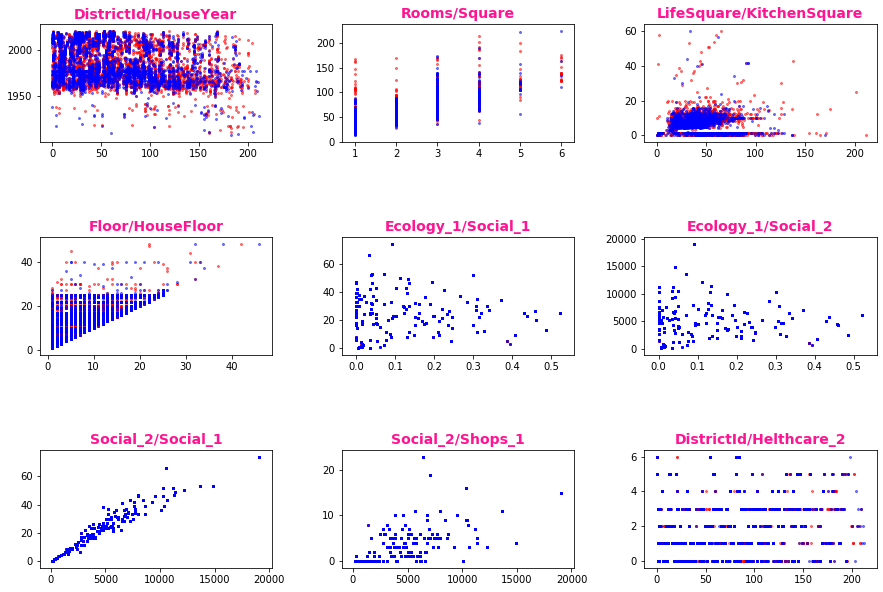

In [120]:
# Еще раз посмотрим на диаграммы
print_first_diagramm(train, test, [[1,0,0,0.5]],[[0,0,1,0.5]],4)

In [121]:
train['price_by_sq']= train['Price']/train['Square']
print(train['price_by_sq'].max())
print(train['price_by_sq'].median())
print(train['price_by_sq'].min())

11854.652892142012
3906.9762073089955
1009.9379963528653


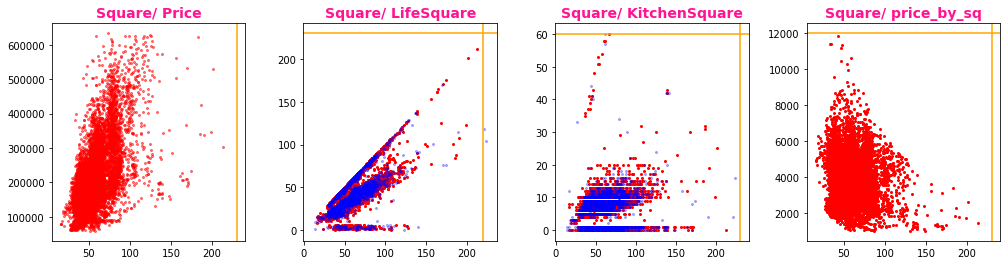

In [122]:
# Посмотрим на диаграммы распределeния  цены от площади, жилой площади от площади и площади кухни от площади
fig, ax = plt. subplots(nrows=1, ncols=4)
ax1, ax2, ax3, ax4 = ax.flatten()
title_font = {
    'fontsize': 14,
    'color': '#FF1493',
    'fontweight': 'bold'
}
ax1.axvline( S_max, color='orange')  # линия отсечки выбросов в признаке площади (Square) более 250 кв. м
ax1.scatter(train['Square'], train['Price'], s =4, c =  [[1, 0, 0, 0.5]])
ax1.set_title('Square/ Price', fontdict=title_font)
ax2.axvline( S_life_max, color='orange')  # линия отсечки  выбросов  LifeSquare более 250 кв. м
ax2.axhline( S_max, color='orange') #  линия отсечки выбросов в признаке площади (Square) более 250 кв. м
ax2.scatter(train['Square'], train['LifeSquare'],s =4, c =  [[1, 0, 0, 1]])
ax2.scatter(test['Square'], test['LifeSquare'],s =4, c =  [[0, 0, 1, 0.3]])
ax2.set_title('Square/ LifeSquare', fontdict=title_font)

ax3.axvline( S_max, color='orange')  # линия отсечки выбросов в признаке площади (Square) более 250 кв. м
ax3.axhline( S_kitch_max, color='orange') #  отметим выбросы площади KitchenSquare более 200 кв. м
ax3.scatter(train['Square'], train['KitchenSquare'],s =4, c =  [[1, 0, 0, 1]])
ax3.set_title('Square/ KitchenSquare', fontdict=title_font)
ax3.scatter(test['Square'], test['KitchenSquare'],s =4, c =  [[0, 0, 1, 0.3]])

ax4.axhline( Price_for_S_max, color='orange') #  отметим выбросы соотношения цены и площади
ax4.axvline( S_max, color='orange')  # линия отсечки выбросов в признаке площади (Square) более 250 кв. м
ax4.scatter(train['Square'], train['price_by_sq'],s =4, c =  [[1, 0, 0, 1]])
ax4.set_title('Square/ price_by_sq', fontdict=title_font)

fig.set_size_inches(17, 4)
plt.subplots_adjust(wspace=0.3, hspace=2.8)

In [123]:
pdim(train,'train')

Dimensions "train"  (9991, 25) <class 'pandas.core.frame.DataFrame'>


# Удалено крайне незначительное количество данных (менее 0.05%)

In [124]:
copy_train = train.copy(deep=True)
copy_test = test.copy(deep=True)
# Для заполнения  недостающих данных в признаке LifeSquare найдем соотношение между площадью объекта  (Square) и жилой площадью (LifeSquare)
k_train_lsq_by_sq= df_kfs_means(train, 'train', 'LifeSquare', S_life_max, 'Square', S_max, 'lsq_by_sq')
k_test_lsq_by_sq= df_kfs_means(test, 'test', 'LifeSquare', S_life_max, 'Square', S_max, 'lsq_by_sq')
k_lsq_by_sq = 0.5*(k_train_lsq_by_sq+k_test_lsq_by_sq)
print('К-т отношения  жилой площади  к площади принимаем ', k_lsq_by_sq)

Значение к-та для train составляет:lsq_by_sq = 0.6311016521550483
Значение к-та для test составляет:lsq_by_sq = 0.6321236844032591
К-т отношения  жилой площади  к площади принимаем  0.6316126682791536


In [125]:
train= df_recalc_sign (train, 'train', 'LifeSquare', 0.55, 'Square', 1.55, k_lsq_by_sq)
test= df_recalc_sign (test, 'test', 'LifeSquare', 0.55, 'Square', 1.55, k_lsq_by_sq)
#s.head(30)

In [126]:
# Для заполнения  недостающих данных в признаке KitchenSquare найдем соотношение между площадью объекта  (Square) и  
#площадью кухни (KitchenSquare)

k_train_ksq_by_sq= df_kfs_means(train, 'train', 'KitchenSquare', S_kitch_max, 'Square', S_max, 'ksq_by_sq')
k_test_ksq_by_sq= df_kfs_means(test, 'test', 'KitchenSquare', S_kitch_max, 'Square', S_max, 'ksq_by_sq')
k_ksq_by_sq = 0.5*(k_train_ksq_by_sq+k_test_ksq_by_sq)
print('К-т отношения   площади кухни к площади объекта принимаем ', k_ksq_by_sq)

Значение к-та для train составляет:ksq_by_sq = 0.12285391245801358
Значение к-та для test составляет:ksq_by_sq = 0.1212483899665172
К-т отношения   площади кухни к площади объекта принимаем  0.1220511512122654


In [127]:
train= df_recalc_sign (train, 'train', 'KitchenSquare', 0.55, 'Square', 1.55, k_ksq_by_sq)
test= df_recalc_sign (test, 'test', 'KitchenSquare', 0.55, 'Square', 1.55, k_ksq_by_sq)

In [128]:
train.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,IsDistrictLarge,price_by_sq,mean_price_district,variant1
0,14038,35,2.0,47.981561,29.442751,6.000000,7.0,9.0,1969.0,0.089040,...,NaN,0,11,B,184966.930730,22,0,3854.958571,4384.628620,0
1,15053,41,3.0,65.683640,40.049543,8.000000,7.0,9.0,1978.0,0.000070,...,240.0,1,16,B,300009.450063,87,0,4567.491245,4293.480295,0
2,4765,53,2.0,44.947953,29.197612,5.485949,8.0,12.0,1968.0,0.049637,...,229.0,1,3,B,220925.908524,174,1,4915.149522,4829.484247,0
3,5809,58,2.0,53.352981,33.698419,9.000000,8.0,17.0,1977.0,0.437885,...,1084.0,0,5,B,175616.227217,179,1,3291.591637,3017.257551,0
4,10783,99,1.0,39.649192,23.776169,7.000000,11.0,12.0,1976.0,0.012339,...,2078.0,2,4,B,150226.531644,97,0,3788.892642,3938.329635,0


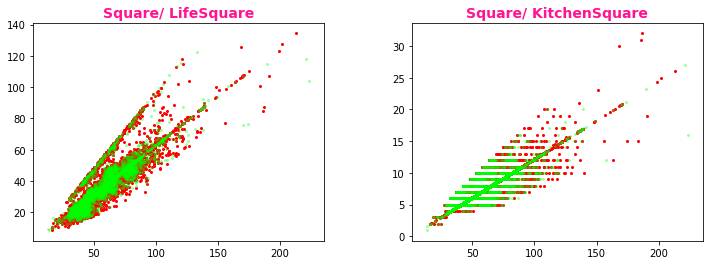

In [129]:
# Посмотрим еще раз на диаграммы  жилой площади от площади и площади кухни от площади
fig, ax = plt. subplots(nrows=1, ncols=2)
ax2, ax3 = ax.flatten()
title_font = {
    'fontsize': 14,
    'color': '#FF1493',
    'fontweight': 'bold'
}

#ax2.axvline( 280, color='red')  # линия отсечки  выбросов  LifeSquare более 280 кв. м
#ax2.axhline( 280, color='blue') #  линия отсечки выбросов в признаке площади (Square) более 280 кв. м
ax2.scatter(train['Square'], train['LifeSquare'],s =4, c =  [[1, 0, 0, 1]])
ax2.scatter(test['Square'], test['LifeSquare'],s =4, c =  [[0, 1, 0, 0.3]])
ax2.set_title('Square/ LifeSquare', fontdict=title_font)
#ax3.axvline( 280, color='red') # отметим выбросы площади KitchenSquare более 200 кв. м
ax3.scatter(train['Square'],train['KitchenSquare'],s =4, c =  [[1, 0, 0, 1]])
ax3.set_title('Square/ KitchenSquare', fontdict=title_font)
ax3.scatter(test['Square'], test['KitchenSquare'],s =4, c =  [[0, 1, 0, 0.3]])

fig.set_size_inches(12, 4)
plt.subplots_adjust(wspace=0.3, hspace=2.8)

In [130]:
train = df_categ_sign(train, 'Ecology_2', 'Ecology_3', "Shops_2",0,1)


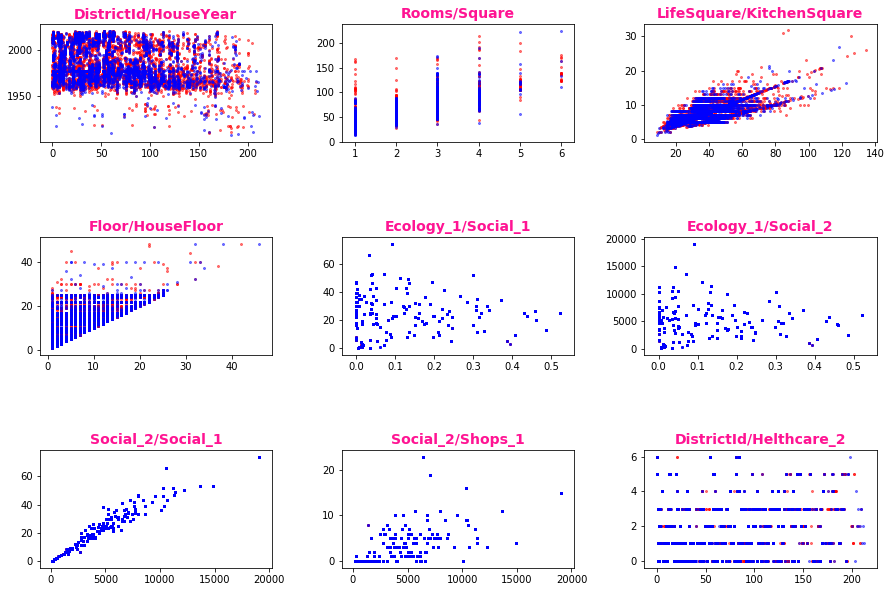

In [131]:
print_first_diagramm(train, test, [[1,0,0,0.5]],[[0,0,1,0.5]],4)

In [132]:
train.describe(include='all').transpose()

,count,mean,std,min,25%,50%,75%,max
Id,9991.0,8382.013512,4858.522341,0.000000,4167.500000,8394.000000,12590.500000,16798.000000
DistrictId,9991.0,50.390051,43.586981,0.000000,20.000000,36.000000,75.000000,209.000000
Rooms,9991.0,1.904314,0.850162,1.000000,1.000000,2.000000,2.000000,6.000000
Square,9991.0,56.261960,18.944866,15.988889,41.878857,52.599854,65.970123,212.932361
LifeSquare,9991.0,35.484796,13.615263,8.822988,24.985440,32.949302,43.336604,134.490777
KitchenSquare,9991.0,7.177040,2.422898,1.951462,5.025799,6.793351,8.783435,32.000000
Floor,9991.0,7.919828,5.187889,1.000000,4.000000,7.000000,11.000000,42.000000
HouseFloor,9991.0,13.539486,5.776330,1.000000,9.000000,14.000000,17.000000,48.000000
HouseYear,9991.0,1984.866180,18.408680,1910.000000,1974.000000,1977.000000,2001.000000,2020.000000
Ecology_1,9991.0,0.118880,0.119066,0.000000,0.017647,0.075424,0.195781,0.521867


In [133]:
#sns.boxplot(train['mean_price_district'], train['price_by_sq'])

mu = 3888.62 and sigma = 1248.18


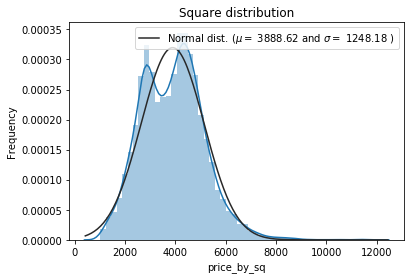

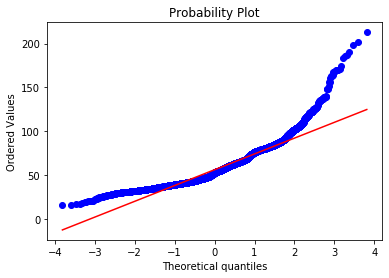

In [134]:
sns.distplot(train['price_by_sq'], fit=norm)

mu, sigma = norm.fit(train['price_by_sq'])

print(f'mu = {mu:.2f} and sigma = {sigma:.2f}')

plt.legend(
    [f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f} )'])
plt.ylabel('Frequency')
plt.title('Square distribution')

# QQ-plot
fig = plt.figure()
res = stats.probplot(train['Square'], plot=plt)
plt.show()

In [135]:
col_with_NULL(train)

Столбцы содержащие NULL:
Healthcare_1    4793
dtype: int32


# Вычисления

In [136]:
#Разбивка датасета на тестовый и валидационный
train_FINAL = train.copy(deep=True)
test_FINAL = test.copy(deep=True)
from sklearn.model_selection import train_test_split
teach, verif = train_test_split(train, test_size=0.3, random_state=42)
pdim(teach, 'teach')
pdim(verif, 'verif')

Dimensions "teach"  (6993, 25) <class 'pandas.core.frame.DataFrame'>
Dimensions "verif"  (2998, 25) <class 'pandas.core.frame.DataFrame'>


In [137]:
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.metrics import r2_score as r2

In [138]:
df_info(test_FINAL)

Информация о данных датафрейма:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 20 columns):
Id               5000 non-null int64
DistrictId       5000 non-null int64
Rooms            5000 non-null float64
Square           5000 non-null float64
LifeSquare       5000 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null float64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null float64
Ecology_1        5000 non-null float64
Ecology_2        5000 non-null object
Ecology_3        5000 non-null object
Social_1         5000 non-null int64
Social_2         5000 non-null int64
Social_3         5000 non-null int64
Healthcare_1     2623 non-null float64
Helthcare_2      5000 non-null int64
Shops_1          5000 non-null int64
Shops_2          5000 non-null object
DistrictSize     5000 non-null int64
dtypes: float64(9), int64(8), object(3)
memory usage: 1.2 MB
---------------------------------------

In [139]:
col_with_NULL(test_FINAL)

Столбцы содержащие NULL:
Healthcare_1    2377
dtype: int32


In [140]:
test_FINAL.isna().any()

Id               False
DistrictId       False
Rooms            False
Square           False
LifeSquare       False
KitchenSquare    False
Floor            False
HouseFloor       False
HouseYear        False
Ecology_1        False
Ecology_2        False
Ecology_3        False
Social_1         False
Social_2         False
Social_3         False
Healthcare_1      True
Helthcare_2      False
Shops_1          False
Shops_2          False
DistrictSize     False
dtype: bool

In [141]:
model_1 = RFR(n_estimators= 800, min_samples_leaf=1, n_jobs=-1
                                     , random_state=42, max_features= 3)

In [142]:
# Список признаков использованных в  моделях
signs = ['DistrictId','LifeSquare','KitchenSquare','HouseYear','HouseFloor','Floor', 'Social_1', 'Social_2',
       'Helthcare_2', 'DistrictSize'] #'Square', 'Shops_1', 'Ecology_1', 'Social_1', 'Social_2','Helthcare_2']
#,'Ecology_2','Ecology_3','Shops_2']'Social_3''Square'

target = 'price_by_sq'

In [143]:
# Функция вычисления набора   предсказываемых данных, метрики R2 (коэф.детерминации) и
# датафрейма с тестовыми и предсказанными данными
def calcR2 (model, teach, verif, col_name, signs):
    #pdim(data, dname)
    
    model.fit(teach.loc[:, signs], teach[col_name])
    test = model.predict(verif.loc[:, signs])
    r2_verif = r2(verif[col_name], test) 
    valid = model.predict(teach.loc[:, signs])
    r2_teach = r2(teach[col_name], valid)
    
    if col_name == 'Price':
        print('Random Forest Regressor:')
        print('Окончательное  значение R2 на предсказанных значениях цены квартиры ')
        print(f'      \n\tr2_verif = {r2_verif:.6f} \n\tr2_teach = {r2_teach:.6f}\n')
        r2_teach_d = 0 
        r2_verif_d = 0
        res_teach_df = pd.DataFrame({
        "Id": teach['Id'],
        "test": teach['Square'],
        "pred": valid,
        })
        res_verif_df = pd.DataFrame({
        "Id": verif['Id'],
        "test": verif[col_name],
        "pred": test,
        })
        #return r2_teach_d, r2_verif_d, res_teach_df, res_verif_df
    else:

        print('Random Forest Regressor:') 
        print('Промежуточное   значения R2 на вспомогательном признаке цена 1 квадратного метра ')
        print(f'      \n\tr2_verif = {r2_verif:.6f} \n\tr2_teach = {r2_teach:.6f}\n')

        res_teach_df = pd.DataFrame({
        "Id": teach['Id'],
        "test": teach[col_name]*teach['Square'],
        "pred": valid*teach['Square'],
        })

        r2_teach_d = r2(res_teach_df['test'], res_teach_df['pred'])

        res_verif_df = pd.DataFrame({
        "Id": verif['Id'],
        "test": verif[col_name]*verif['Square'],
        "pred": test*verif['Square'],
        })


        r2_verif_d = r2(res_verif_df['test'], res_verif_df['pred'])

        print('Окончательное  значение R2 на предсказанных значениях цены квартиры ')
        print(f'      \n\tr2_verif = {r2_verif_d:.6f} \n\tr2_teach = {r2_teach_d:.6f}\n')
    
    return r2_teach_d, r2_verif_d, res_teach_df, res_verif_df

    #check_valid.loc[check_valid['Id']==794]
    #check_valid.shape

## Ответ 1

In [144]:
r2_teach_d1, r2_verif_d1, res_teach_df1, res_verif_df1= calcR2(model_1,teach, verif, target, signs)
res_verif_df1.head(5)

Random Forest Regressor:
Промежуточное   значения R2 на вспомогательном признаке цена 1 квадратного метра 
      
	r2_verif = 0.654659 
	r2_teach = 0.949778

Окончательное  значение R2 на предсказанных значениях цены квартиры 
      
	r2_verif = 0.785349 
	r2_teach = 0.963694



,Id,test,pred
4025,14441,116553.625410,128449.401882
7350,2297,143018.049286,154773.900008
487,6362,253362.894327,271504.086571
39,9371,229778.057902,142920.734150
6801,12891,204657.992220,194287.399392


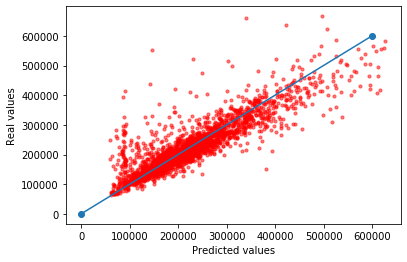

In [145]:
graph_real_predict(res_verif_df1)

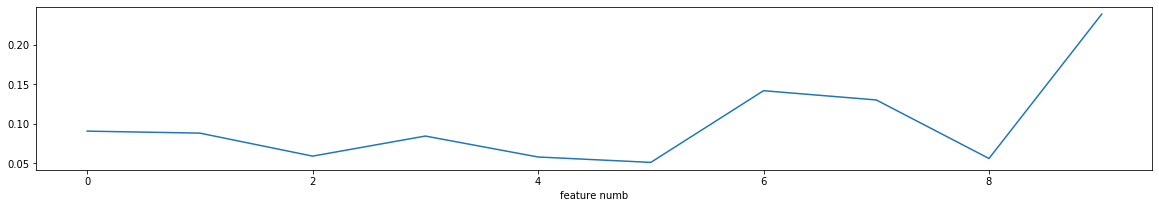

In [146]:
plt.figure(figsize=(20,3))
plt.plot( model_1.feature_importances_)
plt.xlabel('feature numb')
plt.show()

In [147]:
model_2 = RFR(max_depth = 15, max_features = 3, n_estimators = 300, random_state = 42)

In [148]:
# Список признаков использованных в  моделях
signs = ['DistrictId','Rooms','Square','LifeSquare','KitchenSquare','HouseYear','HouseFloor', 'Social_1', 'Social_2',
       'Helthcare_2','Ecology_2','Ecology_3','Shops_2'] 
#'Square', 'Shops_1', 'Ecology_1', 'Social_1', 'Social_2','Helthcare_2']#,'Ecology_2','Ecology_3','Shops_2']'So
target = 'Price'

## Ответ 2

In [149]:
r2_teach_d1_2, r2_verif_d1_2, res_teach_df1_2, res_verif_df1_2 =  calcR2(model_2,teach, verif, target, signs)

Random Forest Regressor:
Окончательное  значение R2 на предсказанных значениях цены квартиры 
      
	r2_verif = 0.748293 
	r2_teach = 0.924287



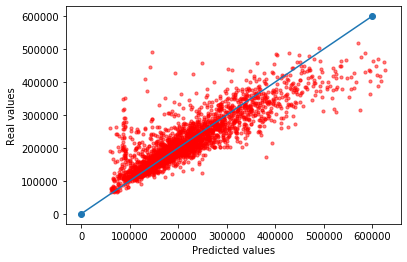

In [150]:
graph_real_predict(res_verif_df1_2)

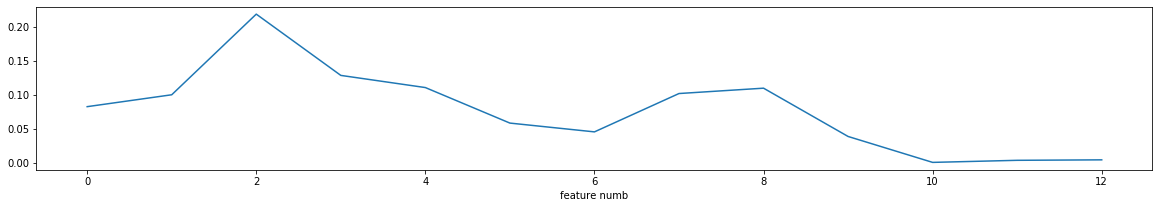

In [151]:
plt.figure(figsize=(20,3))
plt.plot( model_2.feature_importances_)
plt.xlabel('feature numb')

plt.show()

# Автоматизируем процесс очистки данных

In [152]:
def re_data(data_fr):
    
    df = data_fr.copy(deep=True)
    pdim(df, 'df')
    list_inx = []
    
    #HouseYear
    
    print( '\n','*'*30, 'HouseYear','*'*30,'\n')
    print('Максимальный год постройки дома:', Max_Year)    
    i = df.loc[df['HouseYear'] > Max_Year].index
    list_inx.extend(i)
    print(i)
    print('Где  HouseYear > Max_Year установлено значение HouseYear.median =', df['HouseYear'].median(),'в ',len(i),' строках') 
    df.loc[i, 'HouseYear'] = df['HouseYear'].median()
        
    df=df_recalc_sign0(df, '', 'HouseYear', df['HouseYear'].median()) 
    
    #Square
    

    print( '\n','*'*30, 'Square','*'*30,'\n')
    print('Максимальная   площадь:', S_max)
    i = df.loc[df['Square'] < df['LifeSquare']].index
    list_inx.extend(i)
    print(i)
    print('Где  Square < LifeSquare установлено значение LifeSquare в ',len(i),' строках') 
    df.loc[i, 'Square'] =  df['LifeSquare']
    i = df.loc[df['Square'] > S_max].index
    list_inx.extend(i)
    print(i)
    print('Где  Square > S_max установлено значение Square = ', S_max, ' в ',len(i),' строках') 
    df.loc[i, 'Square'] = df['Square'].median()
    df=df_recalc_sign0(df, '', 'Square', df['Square'].median()) 
    
    #Rooms
    
    print( '\n','*'*30, 'Rooms','*'*30,'\n')   
    print('Максимальноя число комнат:', Room_max)
    t = np.round((df['Square']-S_no_life-S_kitch_norm -df['KitchenSquare'])/ S_room,decimals=0)
    i =  df.loc[(df['Rooms'] > Room_max)].index
    list_inx.extend(i)
    print(i)
    print('Где  Rooms > Room_max  установлено значение Rooms в соответствии с Square в ',len(i),\
          ' строках') 
    df.loc[(df['Rooms'] >Room_max), 'Rooms']= np.where(t[i]==0, 1 ,t[i])
    
    i = df.loc[(df['Rooms'] <= 2) & (df['Square'] > MaxSfor2Room)].index
    list_inx.extend(i)
    print(i)
    print('Где Square для однокомнатной или 2-х комнатной квартиры больше ', MaxSfor2Room, \
          'установлено значение Rooms в соответствии с Square в ',len(i),\
          'строках') 
    df.loc[(df['Rooms'] <= 2) & (df['Square'] > MaxSfor2Room), 'Rooms']=np.where(t[i]==0, 1 ,t[i])
    df=df_recalc_sign0(df, '', 'Rooms', df['Rooms'].median())  # Уберем 0 значения 
    
    
    #LifeSquare
    
    print( '\n','*'*30, 'LifeSquare','*'*30,'\n')
    print('Максимальная жилая  площадь:', S_life_max)
    i = df.loc[df['LifeSquare'] > S_life_max].index
    list_inx.extend(i)
    print(i)
    print('Где  LifeSquare > S_life_max установлено значение Square в ',len(i),\
          ' строках') 
    df.loc[i, 'LifeSquare'] =  df['Square']
    df=df_recalc_sign0(df, '', 'LifeSquare', df['LifeSquare'].median())  # Уберем 0 значения 
    
    #KitchenSquare
    
    print( '\n','*'*30, 'KitchenSquare','*'*30,'\n')
    print('Максимальная площадь кухни:', S_kitch_max)
    i = df.loc[(df['KitchenSquare'] > S_kitch_max)].index
    list_inx.extend(i)
    print(i)
    print('Где  KitchenSquare > S_kitch_max установлено значение Square*0.12 в ',len(i),' строках') 
    df.loc[i, 'KitchenSquare']=0.125*df['Square']
    df=df_recalc_sign0(df, '', 'KitchenSquare', df['KitchenSquare'].median())  # Уберем 0 значения 
    
    #HouseFloor
    
    print( '\n','*'*30, 'HouseFloor','*'*30,'\n')
    print('Максимальная этажность :', MaxHouseFloor)
    i = df.loc[df['HouseFloor'] > MaxHouseFloor].index
    list_inx.extend(i)
    print(i)
    print('Где  HouseFloor > MaxHouseFloor установлено значение  HouseFloor.median =', df['HouseFloor'].median(), \
          'в ',len(i),' строках') 
    df.loc[i, 'HouseFloor'] = df['HouseFloor'].median()
    df=df_recalc_sign0(df, '', 'HouseFloor', df['HouseFloor'].median()) 
    
    #Floor
    print( '\n','*'*30, 'Floor','*'*30,'\n')
    print('Максимальный  этаж :', MaxHouseFloor)
    #i = df.loc[df['Floor'] > MaxHouseFloor].index
    #list_inx.extend(i)
    #print(i)
    #print('Где  Floor > MaxHouseFloor установлено значение  Floor.median =', df['Floor'].median(), \
   #       'в ',len(i),' строках') 
    #df.loc[i, 'Floor'] = df['Floor'].median()
    i = df.loc[df['Floor'] > df['HouseFloor']].index
    list_inx.extend(i)
    print(i)
    print('Где  Floor > HouseFloor установлено значение  Floor = HouseFloor и HouseFloor = Floor ', \
          'в ',len(i),' строках') 
    floor_temp = df.loc[i]['Floor']
    df.loc[i, 'Floor'] =df.loc[i, 'HouseFloor']
    df.loc[i, 'HouseFloor'] =floor_temp
    df=df_recalc_sign0(df, '', 'Floor', df['Floor'].median()) 
    
    #DistrictId
    print( '\n','*'*30, 'DistrictId','*'*30,'\n')
    district_size = df['DistrictId'].value_counts().reset_index()\
                .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
    df = df.merge(district_size, on='DistrictId', how='left')
    df['IsDistrictLarge'] = (df['DistrictSize'] > 100).astype(int) # создадим признак IsDistrictLarge
    print( 'Cоздадан признак IsDistrictLarge, 1 - количество записей по району выборке 100, 0 - меньше')
    
    # Проверка Square где Rooms  >= Room_max-1
    print( '\n','*'*30, 'Проверка Square где Rooms  >=5','*'*30,'\n')   
    print('Минимальная площадь комнаты :', S_room_min)
    i =df.loc[df['Rooms'] >= Room_max].index
    list_inx.extend(i)
    print(i)
    print('Установим число комнат в соответствие с площадью ',len(i),'строках') 
    temp = np.round((df['Square']-S_no_life-S_kitch_norm -df['KitchenSquare'])/ S_room_min,decimals=0)
    df.loc[i, 'Rooms']= np.where(t[i]==0, 1 ,t[i])
    
    
    i =df.loc[df['Square']*k_lsq_by_sq/S_room_min <1].index
    list_inx.extend(i)
    print(i)
    print('Откорректируем площадь в квартирах где жить нельзя Square*k_lsq_by_sq/S_room_min <1 в ',len(i),'строках') 
    df.loc[i, 'Square']= df['Square']*10
    
   
    
    df= df_recalc_sign (df, 'df', 'LifeSquare', 0.55, 'Square', 1.55, k_lsq_by_sq)
    df= df_recalc_sign (df, 'df', 'KitchenSquare', 0.55, 'Square', 1.55, k_ksq_by_sq)
    
    
    df = df_categ_sign(df, 'Ecology_2', 'Ecology_3', "Shops_2",0,1)
    
    #df = df.drop(df[df['Rooms']> 6].index)
    df = df.drop(df[df['Square']> S_max].index)
    
    return df,list_inx

In [153]:
train, lisi_change= re_data(train_copy)

Dimensions "df"  (10000, 20) <class 'pandas.core.frame.DataFrame'>

 ****************************** HouseYear ****************************** 

Максимальный год постройки дома: 2020
Int64Index([1497, 4189], dtype='int64')
Где  HouseYear > Max_Year установлено значение HouseYear.median = 1977.0 в  2  строках
Количество замен значения  0 признака " HouseYear " в датафрейме    на  медианное значение  1977.0  =  0

 ****************************** Square ****************************** 

Максимальная   площадь: 230
Int64Index([  28,   44,   52,  123,  153,  178,  184,  212,  217,  234,
            ...
            9807, 9826, 9864, 9871, 9878, 9884, 9889, 9895, 9902, 9910],
           dtype='int64', length=482)
Где  Square < LifeSquare установлено значение LifeSquare в  482  строках
Int64Index([590, 1982, 4262, 4328, 4690, 6977, 8437], dtype='int64')
Где  Square > S_max установлено значение Square =  230  в  7  строках
Количество замен значения  0 признака " Square " в датафрейме    на  медиан

In [154]:
train['price_by_sq']= train['Price']/train['Square']

In [155]:
df_info(train)

Информация о данных датафрейма:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 23 columns):
Id                 10000 non-null int64
DistrictId         10000 non-null int64
Rooms              10000 non-null float64
Square             10000 non-null float64
LifeSquare         10000 non-null float64
KitchenSquare      10000 non-null float64
Floor              10000 non-null float64
HouseFloor         10000 non-null float64
HouseYear          10000 non-null float64
Ecology_1          10000 non-null float64
Ecology_2          10000 non-null int64
Ecology_3          10000 non-null int64
Social_1           10000 non-null int64
Social_2           10000 non-null int64
Social_3           10000 non-null int64
Healthcare_1       5202 non-null float64
Helthcare_2        10000 non-null int64
Shops_1            10000 non-null int64
Shops_2            10000 non-null int64
Price              10000 non-null float64
DistrictSize       10000 non-null int64
I

In [156]:
train.loc[lisi_change].head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,IsDistrictLarge,price_by_sq
1497,10814,109,1.0,37.265070,20.239714,4.548245,9.0,12.0,1977.0,0.136330,...,6141,10,262.0,3,6,1,254084.534396,41,0,6818.302873
4189,11607,147,2.0,44.791836,28.360393,5.000000,4.0,9.0,1977.0,0.319809,...,4756,16,2857.0,5,8,1,243028.603096,15,0,5425.734320
28,8054,23,1.0,43.967759,27.770594,5.366316,3.0,9.0,2014.0,0.034656,...,168,0,NaN,0,0,1,95338.198549,565,1,2168.366114
44,10521,38,3.0,106.340403,67.165945,12.978969,13.0,20.0,2017.0,0.060753,...,2787,2,520.0,0,7,1,435462.048070,36,0,4094.982129
52,2301,1,2.0,65.224603,41.196685,6.000000,17.0,22.0,2016.0,0.007122,...,264,0,NaN,0,1,1,199215.452229,652,1,3054.299201


Корреляция признаков

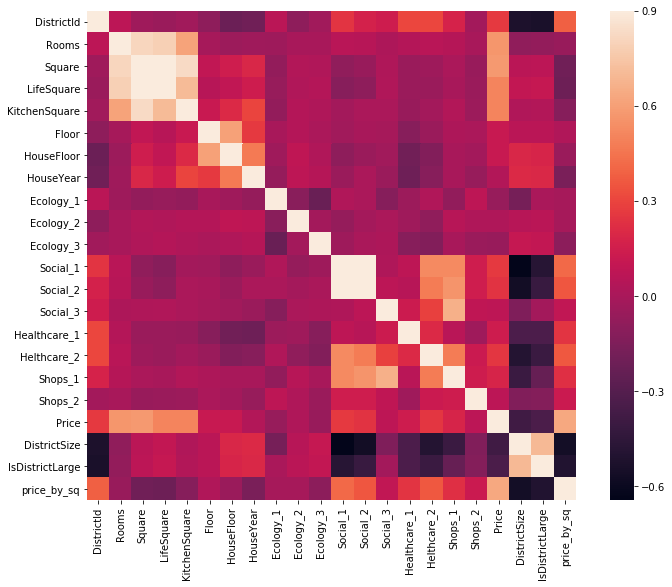

In [157]:
corrmat = train.loc[:, train.columns != 'Id'].corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [158]:
test,lisi_change= re_data(test_copy)

Dimensions "df"  (5000, 19) <class 'pandas.core.frame.DataFrame'>

 ****************************** HouseYear ****************************** 

Максимальный год постройки дома: 2020
Int64Index([], dtype='int64')
Где  HouseYear > Max_Year установлено значение HouseYear.median = 1977.0 в  0  строках
Количество замен значения  0 признака " HouseYear " в датафрейме    на  медианное значение  1977.0  =  0

 ****************************** Square ****************************** 

Максимальная   площадь: 230
Int64Index([   2,   27,   39,   43,   70,  102,  143,  206,  261,  272,
            ...
            4733, 4762, 4779, 4814, 4902, 4927, 4951, 4962, 4969, 4974],
           dtype='int64', length=241)
Где  Square < LifeSquare установлено значение LifeSquare в  241  строках
Int64Index([410], dtype='int64')
Где  Square > S_max установлено значение Square =  230  в  1  строках
Количество замен значения  0 признака " Square " в датафрейме    на  медианное значение  52.93318409490776  =  0

 *******

In [159]:
df_info(test)

Информация о данных датафрейма:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 21 columns):
Id                 5000 non-null int64
DistrictId         5000 non-null int64
Rooms              5000 non-null float64
Square             5000 non-null float64
LifeSquare         5000 non-null float64
KitchenSquare      5000 non-null float64
Floor              5000 non-null float64
HouseFloor         5000 non-null float64
HouseYear          5000 non-null float64
Ecology_1          5000 non-null float64
Ecology_2          5000 non-null int64
Ecology_3          5000 non-null int64
Social_1           5000 non-null int64
Social_2           5000 non-null int64
Social_3           5000 non-null int64
Healthcare_1       2623 non-null float64
Helthcare_2        5000 non-null int64
Shops_1            5000 non-null int64
Shops_2            5000 non-null int64
DistrictSize       5000 non-null int64
IsDistrictLarge    5000 non-null int32
dtypes: float64(9), int3

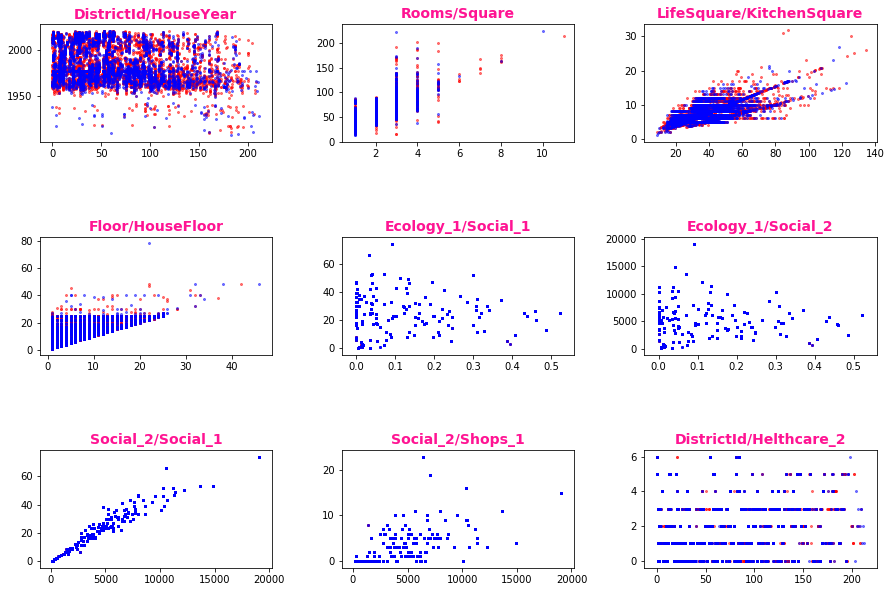

In [160]:
print_first_diagramm(train, test, [[1,0,0,0.5]],[[0,0,1,0.5]],4)

In [161]:
from sklearn.model_selection import train_test_split
teach, verif = train_test_split(train, test_size=0.3, random_state=42)
pdim(teach, 'teach')
pdim(verif, 'verif')

Dimensions "teach"  (7000, 23) <class 'pandas.core.frame.DataFrame'>
Dimensions "verif"  (3000, 23) <class 'pandas.core.frame.DataFrame'>


In [162]:
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.metrics import r2_score as r2

In [163]:
model_3 = RFR(n_estimators= 800, min_samples_leaf=1, n_jobs=-1
                                     , random_state=42, max_features= 3)

In [164]:
# Список признаков использованных в  моделях
signs = ['DistrictId','Square','LifeSquare','KitchenSquare','HouseYear','HouseFloor','Floor', 'Social_1', 'Social_2',
       'Helthcare_2','Ecology_2','Ecology_3','Shops_2','IsDistrictLarge'] #'Square', 'Shops_1', 'Ecology_1', 'Social_1', 'Social_2','Helthcare_2']
#,'Ecology_2','Ecology_3','Shops_2']'Social_3''Square' 'IsDistrictLarge'

target = 'Price'#'price_by_sq'#

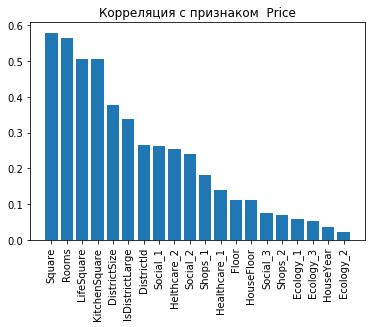

In [165]:
corrmat = train.loc[:, (train.columns != 'Id') & (train.columns != 'Price')].corrwith(
    train['Price']).abs().sort_values(ascending=False)[1:]
plt.bar(corrmat.index, corrmat.values)
plt.title('Корреляция с признаком  Price')
plt.xticks(rotation='vertical')
plt.show()

## Ответ 3

In [166]:
r2_teach_d1_3, r2_verif_d1_3, res_teach_df1_3, res_verif_df1_3 = calcR2(model_3,teach, verif, target, signs)
res_verif_df1_3.head(5)

Random Forest Regressor:
Окончательное  значение R2 на предсказанных значениях цены квартиры 
      
	r2_verif = 0.715234 
	r2_teach = 0.962957



,Id,test,pred
6252,3702,181530.459031,184190.699908
4684,12848,260456.004692,297800.511079
1731,2239,219945.304640,219003.522521
4742,15611,66883.280318,78652.288094
4521,5634,114086.065201,121908.457677


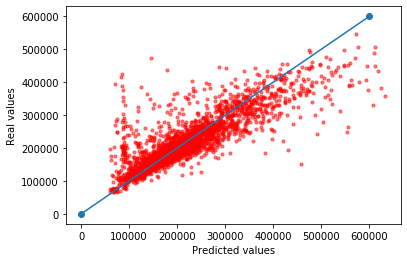

In [167]:
graph_real_predict(res_verif_df1_3)

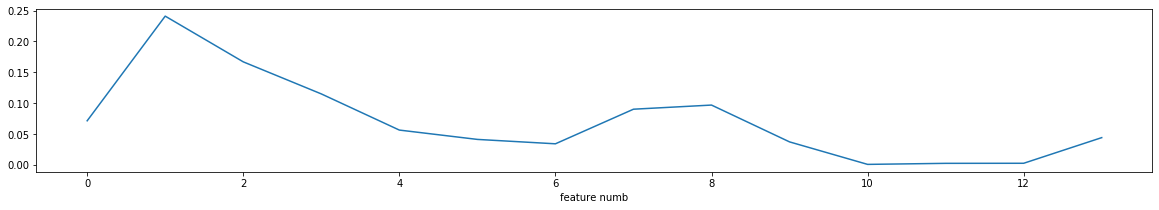

In [168]:
plt.figure(figsize=(20,3))
plt.plot( model_3.feature_importances_)
plt.xlabel('feature numb')
plt.show()

## Учитывая, что метрика R2 показывает лучее значение в ответе 1, используем для предсказания модель 1  и сохраненные наборы train_copy  test_copy


In [169]:
# Список признаков использованных в  модели
signs = ['DistrictId','LifeSquare','KitchenSquare','HouseYear','HouseFloor','Floor', 'Social_1', 
         'Social_2','Helthcare_2', 'DistrictSize']      
#'Square', 'Shops_1', 'Ecology_1', 'Social_1', 'Social_2','Helthcare_2','Ecology_2','Ecology_3','Shops_2'
target = 'price_by_sq'

In [170]:
# Функция вычисления набора   предсказываемых данных, метрики R2 (коэф.детерминации) и
# датафрейма с  предсказанными данными
def calcR2_final(model, teach, verif, col_name, signs):
    model.fit(teach.loc[:, signs], teach[col_name])
    valid = model.predict(teach.loc[:, signs])
    test = model.predict(verif.loc[:, signs])
    
    r2_teach = r2(teach[col_name], valid)
    print('Random Forest Regressor:') 
    print('Промежуточное   значения R2 на вспомогательном признаке цена 1 квадратного метра ')
    print(f' \n\tr2_teach = {r2_teach:.6f}\n')
    res_teach_df = pd.DataFrame({
        "Id": teach['Id'],
        "test": teach[col_name]*teach['Square'],
        "pred": valid*teach['Square'],
        })

    r2_teach_d = r2(res_teach_df['test'], res_teach_df['pred'])

    res_verif_df = pd.DataFrame({
        "Id": verif['Id'],
        "Price": test*verif['Square'],
        })
    print('Окончательное  значение R2 на предсказанных значениях цены квартиры ')
    print(f' \n\tr2_teach = {r2_teach_d:.6f}\n')
    
    return r2_teach_d, res_teach_df, res_verif_df

In [171]:
r2_teach_d1_f, res_teach_df1_f, res_verif_df1_f =  calcR2_final(model_1,train_FINAL, test_FINAL, target, signs)

Random Forest Regressor:
Промежуточное   значения R2 на вспомогательном признаке цена 1 квадратного метра 
 
	r2_teach = 0.951865

Окончательное  значение R2 на предсказанных значениях цены квартиры 
 
	r2_teach = 0.966366



In [172]:
pdim(res_verif_df1_f[['Id', 'Price']], 'final')

Dimensions "final"  (5000, 2) <class 'pandas.core.frame.DataFrame'>


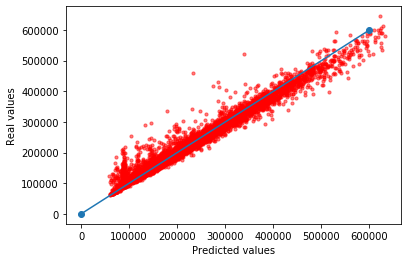

In [173]:
graph_real_predict(res_teach_df1_f)   # График предсказаний на обучающей выборке

In [174]:
res_verif_df1_f[['Id', 'Price']].to_csv('IvanovAL_predictions.csv', index=None)